# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Ajudar a desenvolver o mercado artesanal e independente de bolos e doces.
2. Quais cidades brasileiras a Moça deveria iniciar um programa de incentivo ao empreendedorismo gastronômico artesenal.
3. A proposta deverá considerar a sustentabilidade e escabilidade do negócio.

## Output - Saída

1. Apresentar um parâmetro do que seria o mercado artesanal e independente de bolos e doces.
2. Apresentar indicadores que deveríamos considerar para que uma cidade seja potencial escolhida como um local para incentivo ao empreendedorismo gastronômico.
3. Indicar em termos de receita qual seria o potencial do local escolhido e porquê ele é importante.

## Tasks - Processo

1. **Apresentar um parâmetro do que seria o mercado artesanal e independente de bolos e doces.**
    * Qual é o contexto do mercado artesanal de bolos e doces no Brasil ?
            - Como é composto este mercado (sexo, idade, região)
            - Quais os principais mercados
            - Qual é o potencial em cada região
            - Há um grande volume de lojas pequenas de rua com "bolos caseiros". São potenciais fornecedores para a plataforma Vem de Bolo?
            - Pessoas que vendem pela internet (facebook, whatsapp, instagram). Qual o potencial deste mercado?
            - Quais os principais empecilhos para este tipo de mercado? Uma plataforma on-line (Vem de bolo) poderia dar uma escabilidade aos negócios destas pessoas?
            - Qual é a melhor maneira de atingir o público em termos de comunicação?
            
            
2. **Apresentar indicadores que deveríamos considerar para que uma cidade seja potencial escolhida como um local para incentivo ao empreendedorismo gastronômico.**
    * Quais são os fatores relevantes que a Vem de Bolo pode nos ensinar?
         - **Aprendizado via fornecedor:**
            - Qual é o faturamento médio por fonecedor?
            - Como estes fornecedores estão distribuídos? (cidade/localização)
            - O que caracteriza um fornecedor potencial para a plataforma Vem de Bolo? Quais são os atributos desejáveis?
            - Quais as principais formas de entrega por fornecedor?
         - **Aprendizado via clientes:**
            - Qual é o perfil de compra das pessoas que utilizam a plataforma Vem de Bolo?
            - Qual é o valor de desembolso médio das pessoas?
            - Qual é o tipo de produto que as pessoas mais compram pela plataforma? Isto está relacionado a escolha ou ao viés da oferta?
            - O que determina a escolha do cliente para dado fornecedor? O rating é algo importante / fator de escolha?
    
    
3. **3. Indicar em termos de receita qual seria o potencial do local escolhido e porquê ele é importante.**
    * Dentre os indicadores socio-econômicos, o que faz um local ser viável ao negócio Vem de Bolo?
            - Qual seria o potencial de ganho na cidade escolhida?
            - Há escalabilidade onde poderíamos aumentar a margem sem incorrer de grandes custos (adotar uma cidade que poderia ser um "satélite" de uma região
            - Quais seriam os custos que a Moça deveria investir para viabilizar o negócio da plataforma (marketing, negócio, TI)?

# 0.0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection

from unidecode import unidecode

from scipy import stats as ss
from statsmodels.stats.diagnostic import lilliefors
from sklearn import preprocessing as pp
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import mixture as mx

from plotly import express as px

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

def normal_test(normality_test):
    alpha = 0.05

    sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t = [[], [], [], [], [], [], []]
    name_columns = normality_test.columns

    for i in normality_test:
        if len(normality_test[i])<50:
            # Shapiro-Wilk Test - SAMPLE < 50
            statistic_wb, pvalue_wb = ss.shapiro(normality_test[i])        
            if pvalue_wb > alpha:
                sf_t = sf_t + ["Yes"]
            else:
                sf_t = sf_t + ["No"]
        else:
            sf_t = sf_t + ['Test not possible']

        # D’Agostino’s K-squared test
        k2, p_k2 = ss.normaltest(normality_test[i])
        if p_k2 > alpha:
            k2_t = k2_t + ["Yes"]
        else:
            k2_t = k2_t + ["No"]

        # Anderson-Darling Normality Test
        and_test = ss.anderson(normality_test[i], dist='norm')
        if and_test.statistic < and_test.critical_values[2]: #alpha = 0.05
            and_t = and_t + ["Yes"]
        else:
            and_t = and_t + ["No"]

        # Chi-Square Normality Test
        statistic_q2, pvalue_q2 = ss.chisquare(normality_test[i])
        if pvalue_q2 > alpha:
            q2_t = q2_t + ["Yes"]
        else:
            q2_t = q2_t + ["No"]

        # Lilliefors Test for Normality
        statistic_lillie, pvalue_lillie = lilliefors(normality_test[i])
        if pvalue_lillie > alpha:
            lf_t = lf_t + ["Yes"]
        else:
            lf_t = lf_t + ["No"]

        #Jarque–Bera test for Normality (SAMPLES > 2000)
        if len(normality_test[i]) > 2000:
            statistic_jb, pvalue_jb = ss.jarque_bera(normality_test[i])
            alpha = 0.05
            if pvalue_jb > alpha:
                jb_t = jb_t + ["Yes"]
            else:
                jb_t = jb_t + ["No"]
        else:
            jb_t = jb_t + ['Test not possible']

        # Kolmogorov-Smirnov test for Normality
        statistic_ks, pvalue_ks = ss.kstest(normality_test[i], 'norm')
        if pvalue_ks > alpha:
            ks_t = ks_t + ["Yes"]
        else:
            ks_t = ks_t + ["No"]

    normal_t = pd.DataFrame([sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t], columns=name_columns).T
    normal_t.columns = ['Shapiro-Wilk Test', 'D’Agostino’s K-squared',
                    'Anderson-Darling', 'Chi-Square',
                    'Lilliefors', 'Jarque–Bera', 'Kolmogorov-Smirnov']
    
    return normal_t

pd.options.display.float_format = '{:.2f}'.format

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
df_solds_cognatis = pd.read_csv('../data/raw/tb_solds_cognatis.csv', delimiter=';')
df_solds_cognatis['UF'] = df_solds_cognatis['UF'].apply(lambda x: str.lower(x) if isinstance(x, str) else x)
df_solds_cognatis['MUNICIPIO'] = df_solds_cognatis['MUNICIPIO'].apply(lambda x: str.lower(x) if isinstance(x, str) else x)
df_solds_cognatis['MUNICIPIO.UF'] = df_solds_cognatis['UF'] + ' / '+ df_solds_cognatis['MUNICIPIO']

In [184]:
df_solds_cognatis.head()

,SETOR_ATIV,UF,MUNICIPIO,CEP,TRABALHADORES,S_RENDA_MEDIA,S_FLUXO_PEDESTRE,S_FLUXO_VEICULOS,S_POP_TOTAL,S_DOM_PART_PERM,S_PCT_CRIANCAS,S_PCT_ADOLESCENTE,S_PCT_JOVENS,S_PCT_ADULTOS,S_PCT_SENIOR,S_PCT_IDOSOS,S_RENDA_MEDIA_FAMILIAR,S_DENSIDADE_POPULACAO_KM2,S_PCT_CLASSE_A,S_PCT_CLASSE_B,S_PCT_CLASSE_C,S_PCT_CLASSE_D,S_PCT_CLASSE_E,S_TX_CRESC_POP,S_TX_CRESC_DOM,S_TX_CRESC_RENDA_MEDIA,S_RENDA_PER_CAPITA,S_COMERCIALIZACAO,S_QTD_EMPRESAS,S_PCT_CNAE_AGRICOLA,S_PCT_CNAE_COMERCIO,S_PCT_CNAE_CONSTR_CIVIL,S_PCT_CNAE_INDUSTRIA,S_PCT_CNAE_SERVICOS,S_PCT_CNAE_OUTROS,S_SEM_FUNC,S_DE_1_4_FUNC,S_DE_5_9_FUNC,S_DE_10_19_FUNC,S_DE_20_49_FUNC,S_DE_50_99_FUNC,S_DE_100_249_FUNC,S_DE_250_499_FUNC,S_DE_500_999_FUNC,S_MAIS1000_FUNC,S_SUPERMERCADO,S_TT_PADARIA,S_ATACADO,S_HIPERMERCADO,S_MINIMERCADO,MUNICIPIO.UF
0,NaN,NaN,NaN,nan,18776.60,1852.33,3.16,4.93,61660.28,22297.53,12.02,13.21,15.78,31.95,17.22,9.82,5372.33,5057.62,5.61,31.25,40.72,19.33,3.10,1.70,3.41,1.35,2028.93,14.77,7202.39,0.81,32.40,6.79,8.03,51.08,0.50,4817.48,708.80,244.79,135.84,79.59,22.88,12.44,4.03,2.00,1.67,8.77,57.61,23.13,2.87,85.97,NaN
1,NaN,ac,rio branco,69900001.00,13125.00,3502.67,4.00,6.00,53376.00,17146.00,15.95,17.56,18.25,30.02,12.17,6.05,2121.07,4036.81,0.61,10.16,39.75,40.52,8.96,1.44,3.03,0.73,684.11,9.48,3624.00,0.61,45.23,4.75,7.01,40.59,1.82,2757.00,324.00,101.00,71.00,42.00,15.00,15.00,3.00,4.00,2.00,3.00,22.00,3.00,9.00,184.00,ac / rio branco
2,NaN,ac,rio branco,69900001.00,18364.00,2477.16,4.00,6.00,73460.00,24698.00,12.57,15.06,17.82,32.40,15.48,6.68,4266.92,6317.30,4.44,27.27,40.43,24.36,3.49,1.34,3.10,0.78,1438.17,12.00,4795.00,0.31,42.17,6.07,5.51,44.67,1.27,3295.00,540.00,190.00,131.00,65.00,19.00,19.00,6.00,2.00,2.00,14.00,29.00,27.00,9.00,111.00,ac / rio branco
3,NaN,ac,sena madureira,nan,960.00,1225.87,0.00,0.00,26675.50,7823.50,14.16,20.74,21.14,29.10,9.55,5.30,1917.38,46.92,0.19,7.22,26.47,37.23,28.89,3.51,5.27,1.84,564.92,7.15,951.50,0.71,55.98,5.07,6.83,30.01,1.40,708.00,100.50,27.00,12.00,3.00,1.00,0.00,0.00,0.50,0.00,3.00,7.50,5.00,1.00,84.00,ac / sena madureira
4,NaN,ac,senador guiomard,nan,1102.00,1272.08,0.00,1.00,11183.00,3732.00,17.36,18.51,19.44,27.60,11.13,5.96,2074.47,119.68,0.27,10.24,31.00,44.16,14.33,2.41,4.13,1.10,693.35,6.18,559.00,1.07,52.42,5.55,7.51,32.56,0.89,423.00,49.00,14.00,5.00,6.00,0.00,0.00,0.00,1.00,0.00,0.00,10.00,0.00,0.00,42.00,ac / senador guiomard


### 0.2.1 Análise CEP
- Considerar que os CEP foram mal inseridos e prevale o que foi digitado em termos de Municipio e UF.
- Toda coluna de CEP será dropada

In [152]:
## Ajustando os CEP por Municipio
#aux = pd.DataFrame(df_solds_cognatis['MUNICIPIO.UF'].unique().tolist())
#aux = aux.rename(columns={0: 'MUNICIPIO.UF'})
#df_solds_cognatis_na = df_solds_cognatis.dropna()
#mun_cep = df_solds_cognatis_na[['MUNICIPIO.UF', 'CEP']].drop_duplicates(subset='MUNICIPIO.UF')
#total = pd.merge(aux, mun_cep, how='left', on='MUNICIPIO.UF')

In [236]:
# Base de dados com os CEP do Brasil
df_cep_br = pd.read_csv('../data/cep_brasil/ceps.csv')
df_cep_br = df_cep_br.rename(columns={'CIDADE': 'MUNICIPIO', 'CEP DE': 'cep_de', 'CEP ATÉ': 'cep_ate'})
df_cep_br['MUNICIPIO'] = df_cep_br['MUNICIPIO'].apply(lambda x: str.lower(x) if isinstance(x, str) else x)
df_cep_br['UF'] = df_cep_br['UF'].apply(lambda x: str.lower(x) if isinstance(x, str) else x)
df_cep_br['MUNICIPIO'] = df_cep_br['MUNICIPIO'].apply(lambda x: unidecode(x) if isinstance(x, str) else x)
df_cep_br['MUNICIPIO.UF'] = df_cep_br['UF'] + ' / '+ df_cep_br['MUNICIPIO']
df_cep_br_ = df_cep_br.copy()
df_cep_br_ = df_cep_br_.dropna()
df_cep_br_ = df_cep_br_[['MUNICIPIO.UF', 'cep_de']]
df_cep_br_ = df_cep_br_.drop_duplicates(subset='MUNICIPIO.UF')

# Juntando os dataframes para verificação dos CEP
df_solds_cognatis_ = df_solds_cognatis.merge(df_cep_br_, how='left', on='MUNICIPIO.UF')

In [235]:
df_cep_br[df_cep_br['MUNICIPIO'] == 'gama']

,UF,MUNICIPIO,cep_de,cep_ate,MUNICIPIO.UF


In [223]:
df_cep_br[df_cep_br['MUNICIPIO.UF'] == 'sp / sao paulo']

,MUNICIPIO.UF,cep_de
5566,sp / sao paulo,1000001


In [237]:
df_solds_cognatis_['CEP_'] = df_solds_cognatis_['CEP'] + 1
df_solds_cognatis_['verificacao_1'] = df_solds_cognatis_.apply(lambda x: 1 if x['CEP'] == x['cep_de'] else 0, axis=1)
df_solds_cognatis_['verificacao_2'] = df_solds_cognatis_.apply(lambda x: 1 if x['CEP_'] == x['cep_de'] else 0, axis=1)

In [240]:
df_solds_cognatis_[(df_solds_cognatis_['verificacao_1'] == 0)
                   & (df_solds_cognatis_['verificacao_2'] == 0) 
                   & ~(df_solds_cognatis_['CEP'].isna())
                   & ~(df_solds_cognatis_['MUNICIPIO'] == 'brasilia')
                   #& (df_solds_cognatis_['MUNICIPIO'] == 'sao paulo')
                  ].head(40)

,SETOR_ATIV,UF,MUNICIPIO,CEP,TRABALHADORES,S_RENDA_MEDIA,S_FLUXO_PEDESTRE,S_FLUXO_VEICULOS,S_POP_TOTAL,S_DOM_PART_PERM,S_PCT_CRIANCAS,S_PCT_ADOLESCENTE,S_PCT_JOVENS,S_PCT_ADULTOS,S_PCT_SENIOR,S_PCT_IDOSOS,S_RENDA_MEDIA_FAMILIAR,S_DENSIDADE_POPULACAO_KM2,S_PCT_CLASSE_A,S_PCT_CLASSE_B,S_PCT_CLASSE_C,S_PCT_CLASSE_D,S_PCT_CLASSE_E,S_TX_CRESC_POP,S_TX_CRESC_DOM,S_TX_CRESC_RENDA_MEDIA,S_RENDA_PER_CAPITA,S_COMERCIALIZACAO,S_QTD_EMPRESAS,S_PCT_CNAE_AGRICOLA,S_PCT_CNAE_COMERCIO,S_PCT_CNAE_CONSTR_CIVIL,S_PCT_CNAE_INDUSTRIA,S_PCT_CNAE_SERVICOS,S_PCT_CNAE_OUTROS,S_SEM_FUNC,S_DE_1_4_FUNC,S_DE_5_9_FUNC,S_DE_10_19_FUNC,S_DE_20_49_FUNC,S_DE_50_99_FUNC,S_DE_100_249_FUNC,S_DE_250_499_FUNC,S_DE_500_999_FUNC,S_MAIS1000_FUNC,S_SUPERMERCADO,S_TT_PADARIA,S_ATACADO,S_HIPERMERCADO,S_MINIMERCADO,MUNICIPIO.UF,cep_de,CEP_,verificacao_1,verificacao_2
1216,NaN,ce,juazeiro do norte,63970000.00,1285.00,3246.02,2.00,5.00,14759.00,4393.00,17.40,16.61,19.42,32.50,9.50,4.59,2489.00,472.29,3.07,11.38,37.83,41.18,6.53,6.25,8.73,0.03,761.22,11.84,598.00,0.17,37.96,5.69,18.73,36.12,1.34,478.00,28.00,10.00,10.00,6.00,2.00,2.00,1.00,0.00,0.00,0.00,11.00,0.00,0.00,39.00,ce / juazeiro do norte,63000001.00,63970001.00,0,0
1405,NaN,df,distrito federal,70000001.00,13118.00,1684.55,4.00,6.00,91135.00,32165.00,11.54,12.96,15.39,34.22,17.56,8.33,5000.22,8198.97,1.61,42.21,47.05,8.72,0.41,0.55,2.34,0.49,1770.93,14.16,8673.00,0.02,36.70,5.70,6.83,50.46,0.30,6305.00,870.00,248.00,143.00,67.00,16.00,12.00,1.00,0.00,1.00,0.00,103.00,0.00,3.00,63.00,df / distrito federal,nan,70000002.00,0,0
1406,NaN,df,gama,70000001.00,214634.00,3612.29,4.00,6.00,76848.00,27268.00,11.34,14.74,13.87,35.66,14.58,9.80,5436.56,6938.67,1.69,42.68,44.63,10.94,0.05,0.81,2.60,1.38,1933.01,9.51,8707.00,0.17,31.79,6.48,7.80,52.11,1.65,6446.00,877.00,241.00,135.00,77.00,16.00,12.00,1.00,1.00,9.00,0.00,128.00,0.00,3.00,91.00,df / gama,nan,70000002.00,0,0
1407,NaN,df,sobradinho,73000001.00,0.00,0.00,1.00,4.00,762.00,237.00,15.88,15.75,13.52,28.48,14.97,11.42,1966.94,7.19,0.00,11.81,53.58,32.07,2.53,3.00,4.03,4.71,611.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,df / sobradinho,nan,73000002.00,0,0
1408,NaN,df,taguatinga,70000001.00,10206.00,1665.38,3.00,6.00,73957.00,30099.00,12.71,9.92,14.50,43.92,14.43,4.53,13292.31,6701.40,19.09,69.30,11.15,0.42,0.04,18.05,20.81,7.93,5413.07,12.37,7999.00,0.14,21.30,4.78,4.69,68.83,0.26,5185.00,700.00,180.00,104.00,75.00,15.00,11.00,3.00,1.00,0.00,0.00,112.00,0.00,1.00,21.00,df / taguatinga,nan,70000002.00,0,0
1409,NaN,df,taguatinga norte,70000001.00,3346.00,1438.71,1.00,6.00,40150.00,12477.00,12.12,14.25,14.27,39.25,15.50,4.60,9019.53,3620.69,7.49,63.24,25.38,3.49,0.39,10.47,12.02,1.24,2810.19,3.11,3639.00,0.25,29.87,8.22,8.41,52.73,0.52,2620.00,375.00,81.00,46.00,21.00,4.00,4.00,0.00,0.00,0.00,0.00,49.00,0.00,1.00,35.00,df / taguatinga norte,nan,70000002.00,0,0
1652,NaN,mg,araxa,38160000.00,4920.00,1806.24,3.00,5.00,21135.00,7840.00,11.78,11.33,14.50,31.71,19.40,11.28,5026.48,292.39,7.37,35.41,40.92,15.71,0.59,1.76,3.58,2.27,1869.87,16.03,1667.00,0.30,28.79,8.82,8.22,53.15,0.72,1120.00,226.00,58.00,42.00,33.00,8.00,5.00,1.00,1.00,0.00,0.00,13.00,0.00,1.00,19.00,mg / araxa,38180001.00,38160001.00,0,0
1736,NaN,mg,curvelo,35789001.00,960.00,1357.55,3.00,5.00,17776.00,6172.00,11.14,14.01,17.57,29.65,17.01,10.62,3374.89,1124.48,2.11,13.46,39.18,40.83,4.42,1.24,3.22,2.39,1180.56,12.47,1072.00,1.77,31.34,9.14,10.91,45.80,1.03,818.00,140.00,31.00,8.00,9.00,2.00,0.00,0.00,0.00,0.00,0.00,18.00,0.00,0.00,45.00,mg / curvelo,35789000.00,35789002.00,0,0
1748,NaN,mg,extrema,37820000.00,8403.00,1495.32,0.00,3.00,25177.00,9078.00,18.53,12.57,16.02,30.87,13.77,8.25,3640.93,615.19,1.56,27.92,50.47,19.01,1.02,4.01,5.69,2.65,1315.88,16.18,3630.00,0.28,33.03,7.96,9.97,48.43,0.33,2628.00,396.00,98.00,62.00,29.00,17.00,6.00,1.00,2.00,1.00,0.00,56.00,0.00,0.00,61.00,mg / extrema,37640000.00,37820001.00,0,0
1749,NaN,mg,formig

In [241]:
df_solds_cognatis_[df_solds_cognatis_['MUNICIPIO'].str.contains('santa do paraiso', case=False, na=False)]

,SETOR_ATIV,UF,MUNICIPIO,CEP,TRABALHADORES,S_RENDA_MEDIA,S_FLUXO_PEDESTRE,S_FLUXO_VEICULOS,S_POP_TOTAL,S_DOM_PART_PERM,S_PCT_CRIANCAS,S_PCT_ADOLESCENTE,S_PCT_JOVENS,S_PCT_ADULTOS,S_PCT_SENIOR,S_PCT_IDOSOS,S_RENDA_MEDIA_FAMILIAR,S_DENSIDADE_POPULACAO_KM2,S_PCT_CLASSE_A,S_PCT_CLASSE_B,S_PCT_CLASSE_C,S_PCT_CLASSE_D,S_PCT_CLASSE_E,S_TX_CRESC_POP,S_TX_CRESC_DOM,S_TX_CRESC_RENDA_MEDIA,S_RENDA_PER_CAPITA,S_COMERCIALIZACAO,S_QTD_EMPRESAS,S_PCT_CNAE_AGRICOLA,S_PCT_CNAE_COMERCIO,S_PCT_CNAE_CONSTR_CIVIL,S_PCT_CNAE_INDUSTRIA,S_PCT_CNAE_SERVICOS,S_PCT_CNAE_OUTROS,S_SEM_FUNC,S_DE_1_4_FUNC,S_DE_5_9_FUNC,S_DE_10_19_FUNC,S_DE_20_49_FUNC,S_DE_50_99_FUNC,S_DE_100_249_FUNC,S_DE_250_499_FUNC,S_DE_500_999_FUNC,S_MAIS1000_FUNC,S_SUPERMERCADO,S_TT_PADARIA,S_ATACADO,S_HIPERMERCADO,S_MINIMERCADO,MUNICIPIO.UF,cep_de,CEP_,verificacao_1,verificacao_2
1821,NaN,mg,santa do paraiso,nan,970.00,1279.65,2.00,5.00,9567.00,3131.00,16.36,13.41,16.99,32.60,13.67,6.97,3176.23,108.92,1.02,26.41,42.67,28.68,1.21,5.79,7.27,4.74,1071.87,11.05,795.00,0.13,25.91,8.68,11.19,53.96,0.13,573.00,50.00,16.00,17.00,13.00,2.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,8.00,mg / santa do paraiso,nan,nan,0,0


In [134]:
df_cep_br.shape

(5794, 4)

### 0.2.3 DF POPULAÇÃO MUNICIPIO

In [21]:
df_municipios = pd.read_excel('../data/external/POP2020_20210331.xls', sheet_name='Municípios', header=1, skipfooter=23)
df_municipios = df_municipios.drop(columns=['COD. UF', 'COD. MUNIC'])
df_municipios['NOME DO MUNICÍPIO'] = df_municipios['NOME DO MUNICÍPIO'].apply(lambda x: str.lower(x))
df_municipios['UF'] = df_municipios['UF'].apply(lambda x: str.lower(x))
df_municipios['NOME DO MUNICÍPIO'] = df_municipios['NOME DO MUNICÍPIO'].apply(lambda x: unidecode(x))
df_municipios['MUNICIPIO.UF'] = df_municipios['UF'] + ' / ' + df_municipios['NOME DO MUNICÍPIO']
df_municipios = df_municipios.rename(columns={'POPULAÇÃO ESTIMADA': 'POP_ESTIMADA'})
df_municipios = df_municipios[['MUNICIPIO.UF', 'POP_ESTIMADA']]

In [22]:
df_solds_cognatis_ = df_solds_cognatis.merge(df_municipios, on='MUNICIPIO.UF', how='left')
df_solds_cognatis_.shape

(82391, 52)

In [23]:
df_na = df_solds_cognatis_[df_solds_cognatis_['POP_ESTIMADA'].isna()]
rm_index = df_na.index.tolist()
df_solds_cognatis_rm = df_solds_cognatis_[~df_solds_cognatis_.index.isin(rm_index)]
df_na = df_na.drop(columns=['MUNICIPIO.UF', 'POP_ESTIMADA'])
df_solds_cognatis_.shape

(82391, 52)

In [11]:
df_na.isna().sum()

SETOR_ATIV                   48
UF                            1
MUNICIPIO                     1
CEP                          38
TRABALHADORES                 0
S_RENDA_MEDIA                 0
S_FLUXO_PEDESTRE              0
S_FLUXO_VEICULOS              0
S_POP_TOTAL                   0
S_DOM_PART_PERM               0
S_PCT_CRIANCAS                0
S_PCT_ADOLESCENTE             0
S_PCT_JOVENS                  0
S_PCT_ADULTOS                 0
S_PCT_SENIOR                  0
S_PCT_IDOSOS                  0
S_RENDA_MEDIA_FAMILIAR        0
S_DENSIDADE_POPULACAO_KM2     0
S_PCT_CLASSE_A                0
S_PCT_CLASSE_B                0
S_PCT_CLASSE_C                0
S_PCT_CLASSE_D                0
S_PCT_CLASSE_E                0
S_TX_CRESC_POP                0
S_TX_CRESC_DOM                0
S_TX_CRESC_RENDA_MEDIA        0
S_RENDA_PER_CAPITA            0
S_COMERCIALIZACAO             0
S_QTD_EMPRESAS                0
S_PCT_CNAE_AGRICOLA           0
S_PCT_CNAE_COMERCIO           0
S_PCT_CN

In [13]:
map_ = {'olho d agua das flores': 'olho d\'agua das flores', 
       'olho d agua do casado': 'olho d\'agua do casado',
       'tanque d arca': 'tanque d\'arca', 
       'dias d avila': 'dias d\'avila', 
       'distrito federal': 'brasilia', 
       'gama': 'brasilia',
       'sobradinho': 'brasilia', 
       'taguatinga': 'brasilia', 
       'taguatinga norte': 'brasilia', 
       'santa do paraiso': 'santana do paraiso',
       'mirassol d oeste': 'mirassol d\'oeste', 
       'igarape miri': 'igarape-miri', 
       'santa isabel do para': 'santa izabel do para',
       'santo agostinho': 'cabo de santo agostinho', 
       'olho d agua do piaui': 'olho d\'agua do piaui', 
       'pau d arco do piaui': 'pau d\'arco do piaui',
       'itapejara d oeste': 'itapejara d\'oeste', 
       'assu': 'acu', 
       'lagoa d anta': 'lagoa d\'anta',
       'alta floresta d oeste': 'alta floresta d\'oeste', 
       'alvorada d oeste': 'alvorada d\'oeste', 
       'espigao d oeste': 'espigao d\'oeste',
       'ji parana': 'ji-parana', 
       'machadinho d oeste': 'machadinho d\'oeste', 
       'nova brasilandia d oeste': 'nova brasilandia d\'oeste',
       'santa luzia d oeste': 'santa luzia d\'oeste', 
       'santana do livramento': 'sant\'ana do livramento',
       'amparo de sao francisco': 'amparo do sao francisco', 
       'barras dos coqueiros': 'barra dos coqueiros',
       'itaporanga d ajuda': 'itaporanga d\'ajuda', 
       'biritiba-mirim': 'biritiba mirim', 
       'embu': 'embu das artes', 
       'embu guacu': 'embu-guacu',
       'santa barbara d oeste': 'santa barbara d\'oeste', 
       'saopaulo': 'sao paulo', 
       'fortaleza do tabocao': 'tabocao',
       'olho d:agua das flores': 'olho d\'agua das flores', 
       'olho d:agua do casado': 'olho d\'agua do casado',
       'olho d:agua grande': 'olho d\'agua grande', 
       'tanque d:arca': 'tanque d\'arca', 
       'dias d:avila': 'dias d\'avila',
       'muquem de sao francisco': 'muquem do sao francisco', 
       'santa teresinha': 'santa terezinha', 
       'bom jesus': 'bom jesus de goias',
       'sao joao d:alianca': 'sao joao d\'alianca', 
       'olho d:agua das cunhas': 'olho d\'agua das cunhas', 
       'pindare mirim': 'pindare-mirim',
       'amparo da serra': 'amparo do serra', 
       'barao do monte alto': 'barao de monte alto', 
       'brasopolis': 'brazopolis',
       'olhos-d:agua': 'olhos-d\'agua', 
       'pingo d:agua': 'pingo-d\'agua', 
       'conquista d:oeste': 'conquista d\'oeste',
       'figueiropolis d:oeste': 'figueiropolis d\'oeste', 
       'gloria d:oeste': 'gloria d\'oeste', 
       'lambari d:oeste': 'lambari d\'oeste',
       'mirassol d:oeste': 'mirassol d\'oeste', 
       'poxoreo': 'poxoreu', 
       'eldorado dos carajas': 'eldorado do carajas',
       'mae d:agua': 'mae d\'agua', 
       'olho d:agua': 'olho d\'agua', 
       'belem de sao francisco': 'belem do sao francisco', 
       'iguaraci': 'iguaracy',
       'lagoa do itaenga': 'lagoa de itaenga', 
       'barra d:alcantara': 'barra d\'alcantara', 
       'pau d:arco do piaui': 'pau d\'arco do piaui',
       'diamante d:oeste': 'diamante d\'oeste', 
       'itapejara d:oeste': 'itapejara d\'oeste', 
       'perola d:oeste': 'perola d\'oeste',
       'rancho alegre d:oeste': 'rancho alegre d\'oeste', 
       'sao jorge d:oeste': 'sao jorge d\'oeste', 
       'boa saude': 'januario cicco',
       'lagoa d:anta': 'lagoa d\'anta', 
       'olho d:agua do borges': 'olho d\'agua do borges', 
       'alta floresta d:oeste': 'alta floresta d\'oeste',
       'alvorada d:oeste': 'alvorada d\'oeste', 
       'espigao d:oeste': 'espigao d\'oeste', 
       'espigao doeste': 'espigao d\'oeste',
       'machadinho d:oeste': 'machadinho d\'oeste', 
       'nova brasilandia d:oeste': 'nova brasilandia d\'oeste',
       'santa luzia d:oeste': 'santa luzia d\'oeste', 
       'entre ijuis': 'entre-ijuis', 
       'balneario de picarras': 'balneario picarras',
       'herval d:oeste': 'herval d\'oeste', 
       'graccho cardoso': 'gracho cardoso', 
       'itaporanga d:ajuda': 'itaporanga d\'ajuda',
       'aparecida d:oeste': 'aparecida d\'oeste', 
       'estrela d:oeste': 'estrela d\'oeste', 
       'guarani d:oeste': 'guarani d\'oeste',
       'mogi-guacu': 'mogi guacu', 
       'palmeira d:oeste': 'palmeira d\'oeste', 
       'santa barbara d:oeste': 'santa barbara d\'oeste',
       'santa clara d:oeste': 'santa clara d\'oeste', 
       'santa rita d:oeste': 'santa rita d\'oeste',
       'sao joao do pau d:alho': 'sao joao do pau d\'alho', 
       'couto de magalhaes': 'couto magalhaes', 
       'pau d:arco': 'pau d\'arco',
       'olho d:agua do piaui': 'olho d\'agua do piaui'}

In [24]:
df_na['MUNICIPIO'] = df_na['MUNICIPIO'].map(map_)
df_na['MUNICIPIO.UF'] = df_na['UF'] + ' / ' + df_na['MUNICIPIO']
df_na_ = df_na.merge(df_municipios, on='MUNICIPIO.UF', how='left')

In [25]:
df_na_.head()

,SETOR_ATIV,UF,MUNICIPIO,CEP,TRABALHADORES,S_RENDA_MEDIA,S_FLUXO_PEDESTRE,S_FLUXO_VEICULOS,S_POP_TOTAL,S_DOM_PART_PERM,S_PCT_CRIANCAS,S_PCT_ADOLESCENTE,S_PCT_JOVENS,S_PCT_ADULTOS,S_PCT_SENIOR,S_PCT_IDOSOS,S_RENDA_MEDIA_FAMILIAR,S_DENSIDADE_POPULACAO_KM2,S_PCT_CLASSE_A,S_PCT_CLASSE_B,S_PCT_CLASSE_C,S_PCT_CLASSE_D,S_PCT_CLASSE_E,S_TX_CRESC_POP,S_TX_CRESC_DOM,S_TX_CRESC_RENDA_MEDIA,S_RENDA_PER_CAPITA,S_COMERCIALIZACAO,S_QTD_EMPRESAS,S_PCT_CNAE_AGRICOLA,S_PCT_CNAE_COMERCIO,S_PCT_CNAE_CONSTR_CIVIL,S_PCT_CNAE_INDUSTRIA,S_PCT_CNAE_SERVICOS,S_PCT_CNAE_OUTROS,S_SEM_FUNC,S_DE_1_4_FUNC,S_DE_5_9_FUNC,S_DE_10_19_FUNC,S_DE_20_49_FUNC,S_DE_50_99_FUNC,S_DE_100_249_FUNC,S_DE_250_499_FUNC,S_DE_500_999_FUNC,S_MAIS1000_FUNC,S_SUPERMERCADO,S_TT_PADARIA,S_ATACADO,S_HIPERMERCADO,S_MINIMERCADO,MUNICIPIO.UF,POP_ESTIMADA
0,NaN,NaN,NaN,nan,18776.60,1852.33,3.16,4.93,61660.28,22297.53,12.02,13.21,15.78,31.95,17.22,9.82,5372.33,5057.62,5.61,31.25,40.72,19.33,3.10,1.70,3.41,1.35,2028.93,14.77,7202.39,0.81,32.40,6.79,8.03,51.08,0.50,4817.48,708.80,244.79,135.84,79.59,22.88,12.44,4.03,2.00,1.67,8.77,57.61,23.13,2.87,85.97,NaN,NaN
1,NaN,al,olho d'agua das flores,nan,517.00,1127.31,0.00,0.00,17454.00,5807.00,15.79,18.17,20.59,27.44,11.87,6.14,1777.67,177.72,0.76,4.11,24.51,46.74,23.89,0.36,2.72,3.32,591.74,0.05,767.20,0.13,62.30,1.04,5.21,30.40,0.91,603.20,79.00,22.00,4.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,8.00,0.00,0.00,73.00,al / olho d'agua das flores,21738
2,NaN,al,olho d'agua do casado,nan,434.00,1384.09,0.00,0.00,7286.00,2295.00,13.76,20.25,22.44,26.98,10.54,6.03,1456.11,30.90,0.00,2.74,17.82,55.25,24.18,1.71,4.18,5.45,462.98,0.00,145.00,0.00,56.55,2.07,4.14,34.48,2.76,113.00,9.00,2.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,5.00,0.00,1.00,16.00,al / olho d'agua do casado,9441
3,NaN,al,olho d'agua do casado,nan,434.00,1384.09,0.00,0.00,7286.00,2295.00,13.76,20.25,22.44,26.98,10.54,6.03,1456.11,30.90,0.00,2.74,17.82,55.25,24.18,1.71,4.18,5.45,462.98,0.00,145.00,0.00,56.55,2.07,4.14,34.48,2.76,113.00,9.00,2.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,5.00,0.00,1.00,16.00,al / olho d'agua do casado,9441
4,NaN,al,tanque d'arca,nan,390.00,1251.18,0.00,0.00,4055.00,1464.00,11.27,16.47,19.13,30.18,12.97,9.96,1284.69,43.55,0.00,0.96,16.80,59.70,22.54,-0.72,1.80,3.37,465.08,0.00,122.00,0.82,40.16,1.64,2.46,51.64,3.28,90.00,10.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,3.00,0.00,0.00,14.00,al / tanque d'arca,6138


In [26]:
df_solds_cognatis_ = pd.concat([df_solds_cognatis_rm, df_na_])
df_solds_cognatis_.shape

(82391, 52)

In [350]:
# Verificando municipios sem habitantes
#df_municipios[df_municipios['MUNICIPIO.UF'].str.contains('terezinha', case=False, na=False)]

# <font color='red'> 1.0. Descrição dos dados </font>

In [27]:
df1 = df_solds_cognatis_.copy()
df1.head()

,SETOR_ATIV,UF,MUNICIPIO,CEP,TRABALHADORES,S_RENDA_MEDIA,S_FLUXO_PEDESTRE,S_FLUXO_VEICULOS,S_POP_TOTAL,S_DOM_PART_PERM,S_PCT_CRIANCAS,S_PCT_ADOLESCENTE,S_PCT_JOVENS,S_PCT_ADULTOS,S_PCT_SENIOR,S_PCT_IDOSOS,S_RENDA_MEDIA_FAMILIAR,S_DENSIDADE_POPULACAO_KM2,S_PCT_CLASSE_A,S_PCT_CLASSE_B,S_PCT_CLASSE_C,S_PCT_CLASSE_D,S_PCT_CLASSE_E,S_TX_CRESC_POP,S_TX_CRESC_DOM,S_TX_CRESC_RENDA_MEDIA,S_RENDA_PER_CAPITA,S_COMERCIALIZACAO,S_QTD_EMPRESAS,S_PCT_CNAE_AGRICOLA,S_PCT_CNAE_COMERCIO,S_PCT_CNAE_CONSTR_CIVIL,S_PCT_CNAE_INDUSTRIA,S_PCT_CNAE_SERVICOS,S_PCT_CNAE_OUTROS,S_SEM_FUNC,S_DE_1_4_FUNC,S_DE_5_9_FUNC,S_DE_10_19_FUNC,S_DE_20_49_FUNC,S_DE_50_99_FUNC,S_DE_100_249_FUNC,S_DE_250_499_FUNC,S_DE_500_999_FUNC,S_MAIS1000_FUNC,S_SUPERMERCADO,S_TT_PADARIA,S_ATACADO,S_HIPERMERCADO,S_MINIMERCADO,MUNICIPIO.UF,POP_ESTIMADA
1,NaN,ac,rio branco,69900001.00,13125.00,3502.67,4.00,6.00,53376.00,17146.00,15.95,17.56,18.25,30.02,12.17,6.05,2121.07,4036.81,0.61,10.16,39.75,40.52,8.96,1.44,3.03,0.73,684.11,9.48,3624.00,0.61,45.23,4.75,7.01,40.59,1.82,2757.00,324.00,101.00,71.00,42.00,15.00,15.00,3.00,4.00,2.00,3.00,22.00,3.00,9.00,184.00,ac / rio branco,413418
2,NaN,ac,rio branco,69900001.00,18364.00,2477.16,4.00,6.00,73460.00,24698.00,12.57,15.06,17.82,32.40,15.48,6.68,4266.92,6317.30,4.44,27.27,40.43,24.36,3.49,1.34,3.10,0.78,1438.17,12.00,4795.00,0.31,42.17,6.07,5.51,44.67,1.27,3295.00,540.00,190.00,131.00,65.00,19.00,19.00,6.00,2.00,2.00,14.00,29.00,27.00,9.00,111.00,ac / rio branco,413418
3,NaN,ac,sena madureira,nan,960.00,1225.87,0.00,0.00,26675.50,7823.50,14.16,20.74,21.14,29.10,9.55,5.30,1917.38,46.92,0.19,7.22,26.47,37.23,28.89,3.51,5.27,1.84,564.92,7.15,951.50,0.71,55.98,5.07,6.83,30.01,1.40,708.00,100.50,27.00,12.00,3.00,1.00,0.00,0.00,0.50,0.00,3.00,7.50,5.00,1.00,84.00,ac / sena madureira,46511
4,NaN,ac,senador guiomard,nan,1102.00,1272.08,0.00,1.00,11183.00,3732.00,17.36,18.51,19.44,27.60,11.13,5.96,2074.47,119.68,0.27,10.24,31.00,44.16,14.33,2.41,4.13,1.10,693.35,6.18,559.00,1.07,52.42,5.55,7.51,32.56,0.89,423.00,49.00,14.00,5.00,6.00,0.00,0.00,0.00,1.00,0.00,0.00,10.00,0.00,0.00,42.00,ac / senador guiomard,23236
5,NaN,al,anadia,nan,5.00,880.00,0.00,0.00,2808.00,992.00,12.71,17.02,19.44,28.81,13.24,8.76,1349.79,27.46,0.71,3.43,22.18,60.28,13.41,-2.19,0.55,1.79,477.70,1.00,5.00,0.00,60.00,0.00,0.00,40.00,0.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,al / anadia,17526


## 1.1. Rename columuns

In [28]:
df1.columns

Index(['SETOR_ATIV', 'UF', 'MUNICIPIO', 'CEP', 'TRABALHADORES',
       'S_RENDA_MEDIA', 'S_FLUXO_PEDESTRE', 'S_FLUXO_VEICULOS', 'S_POP_TOTAL',
       'S_DOM_PART_PERM', 'S_PCT_CRIANCAS', 'S_PCT_ADOLESCENTE',
       'S_PCT_JOVENS', 'S_PCT_ADULTOS', 'S_PCT_SENIOR', 'S_PCT_IDOSOS',
       'S_RENDA_MEDIA_FAMILIAR', 'S_DENSIDADE_POPULACAO_KM2', 'S_PCT_CLASSE_A',
       'S_PCT_CLASSE_B', 'S_PCT_CLASSE_C', 'S_PCT_CLASSE_D', 'S_PCT_CLASSE_E',
       'S_TX_CRESC_POP', 'S_TX_CRESC_DOM', 'S_TX_CRESC_RENDA_MEDIA',
       'S_RENDA_PER_CAPITA', 'S_COMERCIALIZACAO', 'S_QTD_EMPRESAS',
       'S_PCT_CNAE_AGRICOLA', 'S_PCT_CNAE_COMERCIO', 'S_PCT_CNAE_CONSTR_CIVIL',
       'S_PCT_CNAE_INDUSTRIA', 'S_PCT_CNAE_SERVICOS', 'S_PCT_CNAE_OUTROS',
       'S_SEM_FUNC', 'S_DE_1_4_FUNC', 'S_DE_5_9_FUNC', 'S_DE_10_19_FUNC',
       'S_DE_20_49_FUNC', 'S_DE_50_99_FUNC', 'S_DE_100_249_FUNC',
       'S_DE_250_499_FUNC', 'S_DE_500_999_FUNC', 'S_MAIS1000_FUNC',
       'S_SUPERMERCADO', 'S_TT_PADARIA', 'S_ATACADO', 'S_HIPE

In [29]:
# storing columns names
cols_old = ['SETOR_ATIV', 'UF', 'MUNICIPIO', 'CEP', 'TRABALHADORES',
       'S_RENDA_MEDIA', 'S_FLUXO_PEDESTRE', 'S_FLUXO_VEICULOS', 'S_POP_TOTAL',
       'S_DOM_PART_PERM', 'S_PCT_CRIANCAS', 'S_PCT_ADOLESCENTE',
       'S_PCT_JOVENS', 'S_PCT_ADULTOS', 'S_PCT_SENIOR', 'S_PCT_IDOSOS',
       'S_RENDA_MEDIA_FAMILIAR', 'S_DENSIDADE_POPULACAO_KM2', 'S_PCT_CLASSE_A',
       'S_PCT_CLASSE_B', 'S_PCT_CLASSE_C', 'S_PCT_CLASSE_D', 'S_PCT_CLASSE_E',
       'S_TX_CRESC_POP', 'S_TX_CRESC_DOM', 'S_TX_CRESC_RENDA_MEDIA',
       'S_RENDA_PER_CAPITA', 'S_COMERCIALIZACAO', 'S_QTD_EMPRESAS',
       'S_PCT_CNAE_AGRICOLA', 'S_PCT_CNAE_COMERCIO', 'S_PCT_CNAE_CONSTR_CIVIL',
       'S_PCT_CNAE_INDUSTRIA', 'S_PCT_CNAE_SERVICOS', 'S_PCT_CNAE_OUTROS',
       'S_SEM_FUNC', 'S_DE_1_4_FUNC', 'S_DE_5_9_FUNC', 'S_DE_10_19_FUNC',
       'S_DE_20_49_FUNC', 'S_DE_50_99_FUNC', 'S_DE_100_249_FUNC',
       'S_DE_250_499_FUNC', 'S_DE_500_999_FUNC', 'S_MAIS1000_FUNC',
       'S_SUPERMERCADO', 'S_TT_PADARIA', 'S_ATACADO', 'S_HIPERMERCADO',
       'S_MINIMERCADO', 'MUNICIPIO.UF', 'POP_ESTIMADA']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

In [30]:
df1.head()

,setor_ativ,uf,municipio,cep,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_pop_total,s_dom_part_perm,s_pct_criancas,s_pct_adolescente,s_pct_jovens,s_pct_adultos,s_pct_senior,s_pct_idosos,s_renda_media_familiar,s_densidade_populacao_km2,s_pct_classe_a,s_pct_classe_b,s_pct_classe_c,s_pct_classe_d,s_pct_classe_e,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_renda_per_capita,s_comercializacao,s_qtd_empresas,s_pct_cnae_agricola,s_pct_cnae_comercio,s_pct_cnae_constr_civil,s_pct_cnae_industria,s_pct_cnae_servicos,s_pct_cnae_outros,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,municipio.uf,pop_estimada
1,NaN,ac,rio branco,69900001.00,13125.00,3502.67,4.00,6.00,53376.00,17146.00,15.95,17.56,18.25,30.02,12.17,6.05,2121.07,4036.81,0.61,10.16,39.75,40.52,8.96,1.44,3.03,0.73,684.11,9.48,3624.00,0.61,45.23,4.75,7.01,40.59,1.82,2757.00,324.00,101.00,71.00,42.00,15.00,15.00,3.00,4.00,2.00,3.00,22.00,3.00,9.00,184.00,ac / rio branco,413418
2,NaN,ac,rio branco,69900001.00,18364.00,2477.16,4.00,6.00,73460.00,24698.00,12.57,15.06,17.82,32.40,15.48,6.68,4266.92,6317.30,4.44,27.27,40.43,24.36,3.49,1.34,3.10,0.78,1438.17,12.00,4795.00,0.31,42.17,6.07,5.51,44.67,1.27,3295.00,540.00,190.00,131.00,65.00,19.00,19.00,6.00,2.00,2.00,14.00,29.00,27.00,9.00,111.00,ac / rio branco,413418
3,NaN,ac,sena madureira,nan,960.00,1225.87,0.00,0.00,26675.50,7823.50,14.16,20.74,21.14,29.10,9.55,5.30,1917.38,46.92,0.19,7.22,26.47,37.23,28.89,3.51,5.27,1.84,564.92,7.15,951.50,0.71,55.98,5.07,6.83,30.01,1.40,708.00,100.50,27.00,12.00,3.00,1.00,0.00,0.00,0.50,0.00,3.00,7.50,5.00,1.00,84.00,ac / sena madureira,46511
4,NaN,ac,senador guiomard,nan,1102.00,1272.08,0.00,1.00,11183.00,3732.00,17.36,18.51,19.44,27.60,11.13,5.96,2074.47,119.68,0.27,10.24,31.00,44.16,14.33,2.41,4.13,1.10,693.35,6.18,559.00,1.07,52.42,5.55,7.51,32.56,0.89,423.00,49.00,14.00,5.00,6.00,0.00,0.00,0.00,1.00,0.00,0.00,10.00,0.00,0.00,42.00,ac / senador guiomard,23236
5,NaN,al,anadia,nan,5.00,880.00,0.00,0.00,2808.00,992.00,12.71,17.02,19.44,28.81,13.24,8.76,1349.79,27.46,0.71,3.43,22.18,60.28,13.41,-2.19,0.55,1.79,477.70,1.00,5.00,0.00,60.00,0.00,0.00,40.00,0.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,al / anadia,17526


## 1.2. Data dimensions

In [31]:
df1.shape

(82391, 52)

## 1.3. Data types

In [32]:
#df1 = df1['cep'].astype('int64')
df1.dtypes

setor_ativ                    object
uf                            object
municipio                     object
cep                          float64
trabalhadores                float64
s_renda_media                float64
s_fluxo_pedestre             float64
s_fluxo_veiculos             float64
s_pop_total                  float64
s_dom_part_perm              float64
s_pct_criancas               float64
s_pct_adolescente            float64
s_pct_jovens                 float64
s_pct_adultos                float64
s_pct_senior                 float64
s_pct_idosos                 float64
s_renda_media_familiar       float64
s_densidade_populacao_km2    float64
s_pct_classe_a               float64
s_pct_classe_b               float64
s_pct_classe_c               float64
s_pct_classe_d               float64
s_pct_classe_e               float64
s_tx_cresc_pop               float64
s_tx_cresc_dom               float64
s_tx_cresc_renda_media       float64
s_renda_per_capita           float64
s

## 1.4. Check NA

In [33]:
df1.isna().sum()

setor_ativ                   4833
uf                              1
municipio                       1
cep                          2039
trabalhadores                   0
s_renda_media                   0
s_fluxo_pedestre                0
s_fluxo_veiculos                0
s_pop_total                     0
s_dom_part_perm                 0
s_pct_criancas                  0
s_pct_adolescente               0
s_pct_jovens                    0
s_pct_adultos                   0
s_pct_senior                    0
s_pct_idosos                    0
s_renda_media_familiar          0
s_densidade_populacao_km2       0
s_pct_classe_a                  0
s_pct_classe_b                  0
s_pct_classe_c                  0
s_pct_classe_d                  0
s_pct_classe_e                  0
s_tx_cresc_pop                  0
s_tx_cresc_dom                  0
s_tx_cresc_renda_media          0
s_renda_per_capita              0
s_comercializacao               0
s_qtd_empresas                  0
s_pct_cnae_agr

## 1.5. Replace NA

In [35]:
# FILL NA WITH
# Setor Atividade
df1['setor_ativ'] = df1['setor_ativ'].fillna('INDEFINIDO')

# UF / Municipio
df1 = df1.dropna(subset=['municipio'])

# CEP
df1 = df1.drop(columns='cep')

## 1.6. Change dtypes

In [42]:
df1['pop_estimada'] = df1['pop_estimada'].apply(lambda x: re.sub(r'\([^)]*\)', '', x) if isinstance(x, str) else x)
df1['pop_estimada'] = df1['pop_estimada'].astype('float64')
df1['setor_ativ'] = df1['setor_ativ'].apply(lambda x: x.lower())

## 1.7. Descriptive Statistics

In [44]:
num_attributes = df1.select_dtypes(include=['int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attibutes

In [45]:
describe_num(num_attributes)

,attibutes,count,mean,std,25%,50%,75%,min,max,range,skew,kurtosis,unique
0,trabalhadores,82390.00,14437.90,30416.21,1844.00,6011.00,14559.12,0.00,450359.00,450359.00,6.28,52.68,39770.00
1,s_renda_media,82390.00,1790.21,804.29,1309.32,1604.68,2012.45,0.00,30685.60,30685.60,3.80,51.46,69076.00
2,s_fluxo_pedestre,82390.00,2.94,1.51,2.00,3.00,4.00,0.00,5.00,5.00,-0.56,-0.63,689.00
3,s_fluxo_veiculos,82390.00,4.83,1.62,5.00,5.00,6.00,0.00,6.00,6.00,-1.91,2.96,900.00
4,s_pop_total,82390.00,52951.89,39630.80,24174.00,44171.50,72931.75,0.00,286481.50,286481.50,1.16,1.46,62356.00
5,s_dom_part_perm,82390.00,18914.66,14810.40,8296.00,15526.00,25863.38,0.00,118235.00,118235.00,1.44,3.11,46771.00
6,s_pct_criancas,82390.00,12.38,2.81,10.54,12.37,14.17,0.00,60.35,60.35,0.34,2.85,12996.00
7,s_pct_adolescente,82390.00,13.46,2.54,11.79,13.50,15.10,0.00,33.33,33.33,0.14,0.66,12642.00
8,s_pct_jovens,82390.00,16.14,1.85,14.95,16.03,17.19,0.00,66.66,66.66,0.94,14.62,11656.00
9,s_pct_adultos,82390.00,31.76,2.57,30.19,31.90,33.34,0.00,48.67,48.67,-0.22,1.81,12915.00


### 1.7.2. Categorical Attibutes

In [46]:
cat_attributes.apply( lambda x: x.unique().shape[0])

setor_ativ         7
uf                27
municipio       4969
municipio.uf    5238
dtype: int64

# <font color='red'> 2.0. Feature Engineering </font>

In [71]:
df2 = df1.copy()
df2.columns

Index(['setor_ativ', 'uf', 'municipio', 'trabalhadores', 's_renda_media',
       's_fluxo_pedestre', 's_fluxo_veiculos', 's_pop_total',
       's_dom_part_perm', 's_pct_criancas', 's_pct_adolescente',
       's_pct_jovens', 's_pct_adultos', 's_pct_senior', 's_pct_idosos',
       's_renda_media_familiar', 's_densidade_populacao_km2', 's_pct_classe_a',
       's_pct_classe_b', 's_pct_classe_c', 's_pct_classe_d', 's_pct_classe_e',
       's_tx_cresc_pop', 's_tx_cresc_dom', 's_tx_cresc_renda_media',
       's_renda_per_capita', 's_comercializacao', 's_qtd_empresas',
       's_pct_cnae_agricola', 's_pct_cnae_comercio', 's_pct_cnae_constr_civil',
       's_pct_cnae_industria', 's_pct_cnae_servicos', 's_pct_cnae_outros',
       's_sem_func', 's_de_1_4_func', 's_de_5_9_func', 's_de_10_19_func',
       's_de_20_49_func', 's_de_50_99_func', 's_de_100_249_func',
       's_de_250_499_func', 's_de_500_999_func', 's_mais1000_func',
       's_supermercado', 's_tt_padaria', 's_atacado', 's_hipermercad

In [48]:
#df2['pct_pesquisa'] = df2['s_pop_total'] / df2['pop_estimada']
#df2[['municipio.uf', 'pct_pesquisa']].groupby('municipio.uf').sum().sort_values('pct_pesquisa', ascending=False)

In [72]:
# Convertendo valores relativos em população por faixa
df2['s_qtd_criancas'] = (df2['s_pct_criancas'] / 100) * df2['s_pop_total']
df2['s_qtd_adolescente'] = (df2['s_pct_adolescente'] / 100) * df2['s_pop_total']
df2['s_qtd_jovens'] = (df2['s_pct_jovens'] / 100) * df2['s_pop_total']
df2['s_qtd_adultos'] = (df2['s_pct_adultos'] / 100) * df2['s_pop_total']
df2['s_qtd_senior'] = (df2['s_pct_senior'] / 100) * df2['s_pop_total']
df2['s_qtd_idosos'] = (df2['s_pct_idosos'] / 100) * df2['s_pop_total']

# Classificação por renda
df2['faixa_f_renda'] = df2.apply(lambda x: 'baixa' if (x['s_renda_media_familiar'] < 4000) 
                               else 'media' if (x['s_renda_media_familiar'] >= 4000) & (x['s_renda_media_familiar'] < 10000) 
                               else 'alta', axis=1)

# Classificação por porte da cidade
df2['class_cidade'] = df2.apply(lambda x: 'baixa' if (x['pop_estimada'] < 50000) 
                                else 'media_pequena' if (x['pop_estimada'] >= 50000) & (x['pop_estimada'] < 100000)
                                else 'media' if (x['pop_estimada'] >= 100000) & (x['pop_estimada'] < 300000)
                                else 'media_grande' if (x['pop_estimada'] >= 300000) & (x['pop_estimada'] < 500000)
                                else 'grande', axis=1)

# Convertendo valores relativos em população por classe social
df2['s_renda_classe_a'] = (df2['s_pct_classe_a'] / 100) * df2['s_pop_total'] * df2['s_renda_per_capita']
df2['s_renda_classe_b'] = (df2['s_pct_classe_b'] / 100) * df2['s_pop_total'] * df2['s_renda_per_capita']
df2['s_renda_classe_c'] = (df2['s_pct_classe_c'] / 100) * df2['s_pop_total'] * df2['s_renda_per_capita']
df2['s_renda_classe_d'] = (df2['s_pct_classe_d'] / 100) * df2['s_pop_total'] * df2['s_renda_per_capita']
df2['s_renda_classe_e'] = (df2['s_pct_classe_e'] / 100) * df2['s_pop_total'] * df2['s_renda_per_capita']

# Convertendo valores relativos de empresas por valors absolutos
df2['s_qtd_cnae_agricola'] = (df2['s_pct_cnae_agricola'] / 100) * df2['s_qtd_empresas']
df2['s_qtd_cnae_comercio'] = (df2['s_pct_cnae_comercio'] / 100) * df2['s_qtd_empresas']
df2['s_qtd_cnae_constr_civil'] = (df2['s_pct_cnae_constr_civil'] / 100) * df2['s_qtd_empresas']
df2['s_qtd_cnae_industria'] = (df2['s_pct_cnae_industria'] / 100) * df2['s_qtd_empresas']
df2['s_qtd_cnae_servicos'] = (df2['s_pct_cnae_servicos'] / 100) * df2['s_qtd_empresas']
df2['s_qtd_cnae_outros'] = (df2['s_pct_cnae_outros'] / 100) * df2['s_qtd_empresas']

df2 = df2.drop(columns=['s_pct_criancas', 's_pct_adolescente', 's_pct_jovens', 's_pct_adultos', 's_pct_senior', 's_pct_idosos',
                        's_pct_classe_a', 's_pct_classe_b', 's_pct_classe_c', 's_pct_classe_d', 's_pct_classe_d', 's_pct_classe_e',
                        's_pop_total', 's_renda_per_capita',
                        's_pct_cnae_agricola', 's_pct_cnae_comercio', 's_pct_cnae_constr_civil', 's_pct_cnae_industria', 's_pct_cnae_servicos', 's_pct_cnae_outros',
                        's_qtd_empresas',
                        's_renda_media_familiar',
                        'pop_estimada',
                        'uf', 'municipio'
                       ])

In [73]:
df2.sample()

,setor_ativ,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_dom_part_perm,s_densidade_populacao_km2,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_comercializacao,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,municipio.uf,s_qtd_criancas,s_qtd_adolescente,s_qtd_jovens,s_qtd_adultos,s_qtd_senior,s_qtd_idosos,faixa_f_renda,class_cidade,s_renda_classe_a,s_renda_classe_b,s_renda_classe_c,s_renda_classe_d,s_renda_classe_e,s_qtd_cnae_agricola,s_qtd_cnae_comercio,s_qtd_cnae_constr_civil,s_qtd_cnae_industria,s_qtd_cnae_servicos,s_qtd_cnae_outros
48435,comercio,5152.00,1558.61,2.00,5.00,9983.00,1545.94,3.42,5.11,1.60,15.64,1274.00,333.00,84.00,64.00,29.00,6.00,3.00,2.00,1.00,0.00,4.00,17.00,8.00,1.00,16.00,sc / brusque,3047.66,2635.39,4075.73,8566.33,5364.72,2403.17,media,media,2984782.12,29186420.05,20452540.47,3781854.50,124365.92,3.00,522.00,163.00,437.00,877.00,12.08


In [74]:
df2_ = df2.groupby(['setor_ativ','municipio.uf', 'class_cidade','faixa_f_renda']).mean().reset_index()
#df2_['setor_ativ'] = df2[['uf','municipio', 'setor_ativ']].groupby(['uf','municipio']).count().reset_index()['setor_ativ'].values
#df2_ = df2_.drop(columns=['municipio', 'uf', 'cep'])

In [75]:
df2_.head(30)

,setor_ativ,municipio.uf,class_cidade,faixa_f_renda,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_dom_part_perm,s_densidade_populacao_km2,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_comercializacao,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,s_qtd_criancas,s_qtd_adolescente,s_qtd_jovens,s_qtd_adultos,s_qtd_senior,s_qtd_idosos,s_renda_classe_a,s_renda_classe_b,s_renda_classe_c,s_renda_classe_d,s_renda_classe_e,s_qtd_cnae_agricola,s_qtd_cnae_comercio,s_qtd_cnae_constr_civil,s_qtd_cnae_industria,s_qtd_cnae_servicos,s_qtd_cnae_outros
0,agropecuaria,ce / miraima,baixa,baixa,23.00,994.06,0.00,0.00,1694.00,18.43,2.06,4.75,3.97,2.87,112.00,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,21.00,793.80,937.13,1105.12,1383.90,604.80,425.25,5679.99,25462.03,374487.69,1108773.40,444018.60,0.00,73.00,4.00,5.00,39.00,7.00
1,agropecuaria,ce / nova olinda,baixa,baixa,1264.00,696.12,0.00,0.00,3543.00,90.77,2.34,4.63,0.32,4.22,429.00,68.00,18.00,8.00,2.00,2.00,0.00,0.00,1.00,0.00,0.00,6.00,0.00,1.00,41.00,1678.86,1715.26,2295.58,2988.32,1219.53,808.38,26922.86,95725.72,1030048.60,2655391.45,1177625.80,6.00,267.00,15.00,85.00,192.00,15.02
2,agropecuaria,es / cariacica,media_grande,baixa,15231.00,1571.33,4.00,5.00,26791.00,7674.45,0.80,2.69,0.84,13.96,5459.00,728.00,241.00,131.00,64.00,24.00,12.00,4.00,1.00,1.00,15.00,81.00,20.00,3.00,82.00,7783.09,8777.13,10680.60,23024.97,12971.82,7261.40,1638951.49,28847388.19,42235227.22,18590130.37,764230.19,4.00,2558.00,587.00,716.00,3416.00,72.80
3,agropecuaria,es / guacui,baixa,baixa,1.00,919.39,0.00,0.00,344.00,13.56,1.11,3.15,1.83,0.87,14.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,147.01,164.03,155.96,258.99,160.98,97.02,0.00,33703.26,185537.15,245980.58,18278.09,2.00,4.00,0.00,0.00,9.00,0.00
4,agropecuaria,es / viana,media_pequena,baixa,2488.00,1549.71,2.00,5.00,5480.00,355.60,3.07,4.78,1.66,9.54,1199.00,90.00,42.00,26.00,18.00,8.00,3.00,0.00,0.00,0.00,2.00,9.00,8.00,0.00,45.00,2721.33,2737.80,2464.51,5236.88,2253.78,1048.69,14284.29,834202.36,4639536.42,3910085.53,124749.43,5.00,442.00,172.00,184.00,626.00,22.06
5,agropecuaria,go / goiania,grande,alta,74294.00,3550.16,5.00,6.00,31106.00,7832.19,1.20,3.04,-1.02,24.94,10395.00,3195.00,959.00,544.00,344.00,104.00,47.00,24.00,10.00,6.00,20.00,93.00,55.00,7.00,46.00,4866.41,6325.58,11139.34,22143.30,17728.18,13012.19,95846531.41,167722932.97,61438338.44,13260073.59,1700009.39,216.00,4311.00,1172.00,678.00,12712.00,161.71
6,agropecuaria,go / quirinopolis,media_pequena,baixa,6483.00,1818.09,2.00,5.00,9204.00,135.77,1.43,2.65,2.46,15.48,1747.00,410.00,85.00,63.00,25.00,4.00,4.00,1.00,0.00,1.00,22.00,25.00,9.00,4.00,125.00,3330.45,3055.02,3749.92,7959.73,4495.36,2675.99,605553.13,8573164.69,15685661.97,11358709.19,473432.44,52.00,1216.00,117.00,184.00,1010.00,22.11
7,agropecuaria,ma / axixa,baixa,baixa,43.00,995.80,0.00,0.00,461.00,22.79,0.68,2.84,4.49,0.43,30.00,1.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,7.00,308.06,443.09,307.88,451.96,151.86,146.97,4428.93,13286.80,119717.50,317793.07,226148.19,1.00,18.00,1.00,3.00,18.00,0.00
8,agropecuaria,mg / andradas,baixa,baixa,2491.00,1123.68,4.00,5.00,1765.00,89.22,2.31,4.09,0.58,9.40,294.00,79.00,32.00,15.00,4.00,3.00,0.00,0.00,2.00,0.00,3.00,5.00,5.00,0.00,14.00,478.94,543.92,658.88,1476.80,901.98,483.03,134078.34,1801119.11,3096571.41,1255228.73,97685.65,19.00,169.00,33.00,109.00,133.00,5.01
9,agropecuaria,mg / santos dumont,baixa,baixa,4830.00,1244.94,4.00,5.00,10582.00,415.94,0.13,2.07,0.59,13.53,1665.00,449.00,106.00,53.00,19.00,4.00,4.00,1.00,1.00,0.00,6.00,31.00,6.00,4.00,93.00,2694.69,3435.80,4608.51,8086.90,5985.67,3583.45,326341.71,6638636.06,13945064.82,8376103.45,930678.16,27.00,915.00,91.00,228.00,1183.00,27.93


In [76]:
df2_.shape

(12351, 46)

In [77]:
df2 = df2_.copy()

# <font color='red'> 3.0. Filtragem de Variaveis </font>

## 3.1. Row Filtering

## 3.2. Column Filtering

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

# <font color='red'> 5.0. Data Preparation </font>

In [78]:
df5 = df2.copy()
df5.head()

,setor_ativ,municipio.uf,class_cidade,faixa_f_renda,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_dom_part_perm,s_densidade_populacao_km2,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_comercializacao,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,s_qtd_criancas,s_qtd_adolescente,s_qtd_jovens,s_qtd_adultos,s_qtd_senior,s_qtd_idosos,s_renda_classe_a,s_renda_classe_b,s_renda_classe_c,s_renda_classe_d,s_renda_classe_e,s_qtd_cnae_agricola,s_qtd_cnae_comercio,s_qtd_cnae_constr_civil,s_qtd_cnae_industria,s_qtd_cnae_servicos,s_qtd_cnae_outros
0,agropecuaria,ce / miraima,baixa,baixa,23.00,994.06,0.00,0.00,1694.00,18.43,2.06,4.75,3.97,2.87,112.00,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,21.00,793.80,937.13,1105.12,1383.90,604.80,425.25,5679.99,25462.03,374487.69,1108773.40,444018.60,0.00,73.00,4.00,5.00,39.00,7.00
1,agropecuaria,ce / nova olinda,baixa,baixa,1264.00,696.12,0.00,0.00,3543.00,90.77,2.34,4.63,0.32,4.22,429.00,68.00,18.00,8.00,2.00,2.00,0.00,0.00,1.00,0.00,0.00,6.00,0.00,1.00,41.00,1678.86,1715.26,2295.58,2988.32,1219.53,808.38,26922.86,95725.72,1030048.60,2655391.45,1177625.80,6.00,267.00,15.00,85.00,192.00,15.02
2,agropecuaria,es / cariacica,media_grande,baixa,15231.00,1571.33,4.00,5.00,26791.00,7674.45,0.80,2.69,0.84,13.96,5459.00,728.00,241.00,131.00,64.00,24.00,12.00,4.00,1.00,1.00,15.00,81.00,20.00,3.00,82.00,7783.09,8777.13,10680.60,23024.97,12971.82,7261.40,1638951.49,28847388.19,42235227.22,18590130.37,764230.19,4.00,2558.00,587.00,716.00,3416.00,72.80
3,agropecuaria,es / guacui,baixa,baixa,1.00,919.39,0.00,0.00,344.00,13.56,1.11,3.15,1.83,0.87,14.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,147.01,164.03,155.96,258.99,160.98,97.02,0.00,33703.26,185537.15,245980.58,18278.09,2.00,4.00,0.00,0.00,9.00,0.00
4,agropecuaria,es / viana,media_pequena,baixa,2488.00,1549.71,2.00,5.00,5480.00,355.60,3.07,4.78,1.66,9.54,1199.00,90.00,42.00,26.00,18.00,8.00,3.00,0.00,0.00,0.00,2.00,9.00,8.00,0.00,45.00,2721.33,2737.80,2464.51,5236.88,2253.78,1048.69,14284.29,834202.36,4639536.42,3910085.53,124749.43,5.00,442.00,172.00,184.00,626.00,22.06


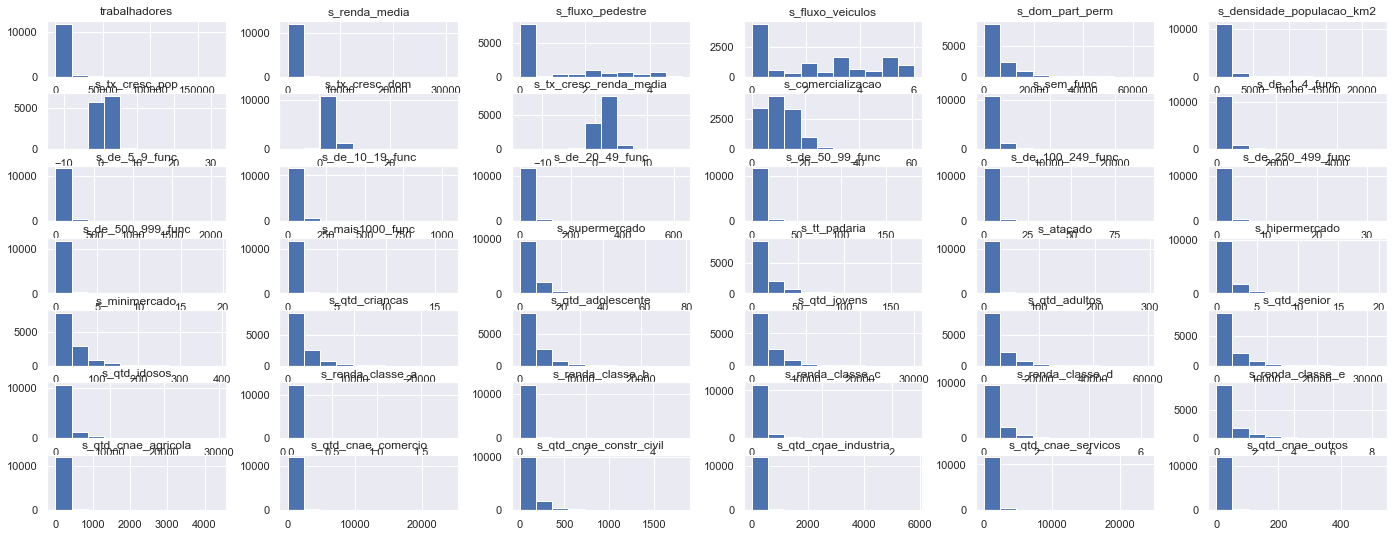

In [79]:
df5.hist();

In [80]:
num_attributes = df5.select_dtypes(include=['int32', 'float64'])
cat_attributes = df5.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

## 5.1. NORMALIZATION

In [81]:
normal_test(num_attributes)

,Shapiro-Wilk Test,D’Agostino’s K-squared,Anderson-Darling,Chi-Square,Lilliefors,Jarque–Bera,Kolmogorov-Smirnov
trabalhadores,Test not possible,No,No,No,No,No,No
s_renda_media,Test not possible,No,No,No,No,No,No
s_fluxo_pedestre,Test not possible,No,No,No,No,No,No
s_fluxo_veiculos,Test not possible,No,No,No,No,No,No
s_dom_part_perm,Test not possible,No,No,No,No,No,No
s_densidade_populacao_km2,Test not possible,No,No,No,No,No,No
s_tx_cresc_pop,Test not possible,No,No,No,No,No,No
s_tx_cresc_dom,Test not possible,No,No,Yes,No,No,No
s_tx_cresc_renda_media,Test not possible,No,No,No,No,No,No
s_comercializacao,Test not possible,No,No,No,No,No,No


## 5.2. RESCALLING

In [82]:
df5_p = df5.copy()
df5 = df5.drop(columns=['setor_ativ', 'municipio.uf', 'class_cidade', 'faixa_f_renda'])
df5.head()

,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_dom_part_perm,s_densidade_populacao_km2,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_comercializacao,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,s_qtd_criancas,s_qtd_adolescente,s_qtd_jovens,s_qtd_adultos,s_qtd_senior,s_qtd_idosos,s_renda_classe_a,s_renda_classe_b,s_renda_classe_c,s_renda_classe_d,s_renda_classe_e,s_qtd_cnae_agricola,s_qtd_cnae_comercio,s_qtd_cnae_constr_civil,s_qtd_cnae_industria,s_qtd_cnae_servicos,s_qtd_cnae_outros
0,23.00,994.06,0.00,0.00,1694.00,18.43,2.06,4.75,3.97,2.87,112.00,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,21.00,793.80,937.13,1105.12,1383.90,604.80,425.25,5679.99,25462.03,374487.69,1108773.40,444018.60,0.00,73.00,4.00,5.00,39.00,7.00
1,1264.00,696.12,0.00,0.00,3543.00,90.77,2.34,4.63,0.32,4.22,429.00,68.00,18.00,8.00,2.00,2.00,0.00,0.00,1.00,0.00,0.00,6.00,0.00,1.00,41.00,1678.86,1715.26,2295.58,2988.32,1219.53,808.38,26922.86,95725.72,1030048.60,2655391.45,1177625.80,6.00,267.00,15.00,85.00,192.00,15.02
2,15231.00,1571.33,4.00,5.00,26791.00,7674.45,0.80,2.69,0.84,13.96,5459.00,728.00,241.00,131.00,64.00,24.00,12.00,4.00,1.00,1.00,15.00,81.00,20.00,3.00,82.00,7783.09,8777.13,10680.60,23024.97,12971.82,7261.40,1638951.49,28847388.19,42235227.22,18590130.37,764230.19,4.00,2558.00,587.00,716.00,3416.00,72.80
3,1.00,919.39,0.00,0.00,344.00,13.56,1.11,3.15,1.83,0.87,14.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,147.01,164.03,155.96,258.99,160.98,97.02,0.00,33703.26,185537.15,245980.58,18278.09,2.00,4.00,0.00,0.00,9.00,0.00
4,2488.00,1549.71,2.00,5.00,5480.00,355.60,3.07,4.78,1.66,9.54,1199.00,90.00,42.00,26.00,18.00,8.00,3.00,0.00,0.00,0.00,2.00,9.00,8.00,0.00,45.00,2721.33,2737.80,2464.51,5236.88,2253.78,1048.69,14284.29,834202.36,4639536.42,3910085.53,124749.43,5.00,442.00,172.00,184.00,626.00,22.06


In [83]:
for i in range(df5.shape[1]):
    mm = pp.MinMaxScaler()
    df5.iloc[:, i] = mm.fit_transform(df5.iloc[:, i].values.reshape(-1, 1))

In [84]:
df5.head()

,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_dom_part_perm,s_densidade_populacao_km2,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_comercializacao,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,s_qtd_criancas,s_qtd_adolescente,s_qtd_jovens,s_qtd_adultos,s_qtd_senior,s_qtd_idosos,s_renda_classe_a,s_renda_classe_b,s_renda_classe_c,s_renda_classe_d,s_renda_classe_e,s_qtd_cnae_agricola,s_qtd_cnae_comercio,s_qtd_cnae_constr_civil,s_qtd_cnae_industria,s_qtd_cnae_servicos,s_qtd_cnae_outros
0,0.00,0.03,0.00,0.00,0.03,0.00,0.33,0.30,0.59,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.05,0.03,0.03,0.04,0.02,0.02,0.01,0.00,0.00,0.00,0.02,0.05,0.00,0.00,0.00,0.00,0.00,0.01
1,0.01,0.02,0.00,0.00,0.05,0.00,0.33,0.30,0.47,0.07,0.02,0.01,0.01,0.01,0.00,0.01,0.00,0.00,0.05,0.00,0.00,0.03,0.00,0.05,0.10,0.07,0.06,0.08,0.05,0.04,0.03,0.00,0.00,0.00,0.04,0.14,0.00,0.01,0.01,0.01,0.01,0.03
2,0.09,0.05,0.80,0.83,0.41,0.35,0.30,0.25,0.49,0.23,0.22,0.14,0.12,0.12,0.10,0.13,0.13,0.12,0.05,0.06,0.19,0.46,0.07,0.15,0.21,0.32,0.33,0.36,0.39,0.40,0.24,0.01,0.06,0.18,0.30,0.09,0.00,0.11,0.32,0.12,0.14,0.14
3,0.00,0.03,0.00,0.00,0.01,0.00,0.30,0.26,0.52,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.01,0.05,0.40,0.83,0.08,0.02,0.35,0.30,0.51,0.16,0.05,0.02,0.02,0.02,0.03,0.04,0.03,0.00,0.00,0.00,0.03,0.05,0.03,0.00,0.12,0.11,0.10,0.08,0.09,0.07,0.04,0.00,0.00,0.02,0.06,0.01,0.00,0.02,0.09,0.03,0.03,0.04


## 5.3. TRANSFORMATION

# <font color='red'> 6.0. Feature Selection </font>

# <font color='red'> 7.0 MACHINE LEARNING MODELLING </font>

In [85]:
X = df5.copy()

In [86]:
clusters = [2, 3, 4, 5, 6, 7]

In [87]:
X.shape

(12351, 42)

## 7.1. Defining the number of Clusers - K-Means

In [88]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )
    #print('Cluster: ', k, 'Silhoutte Score: ', sil)

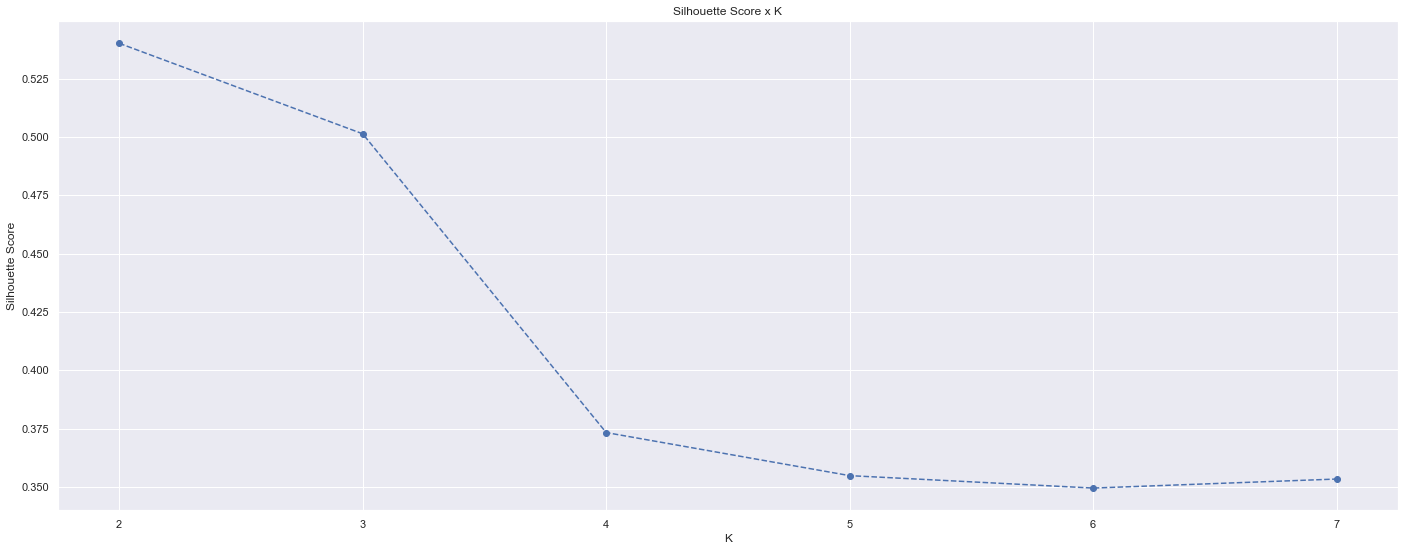

In [89]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [90]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

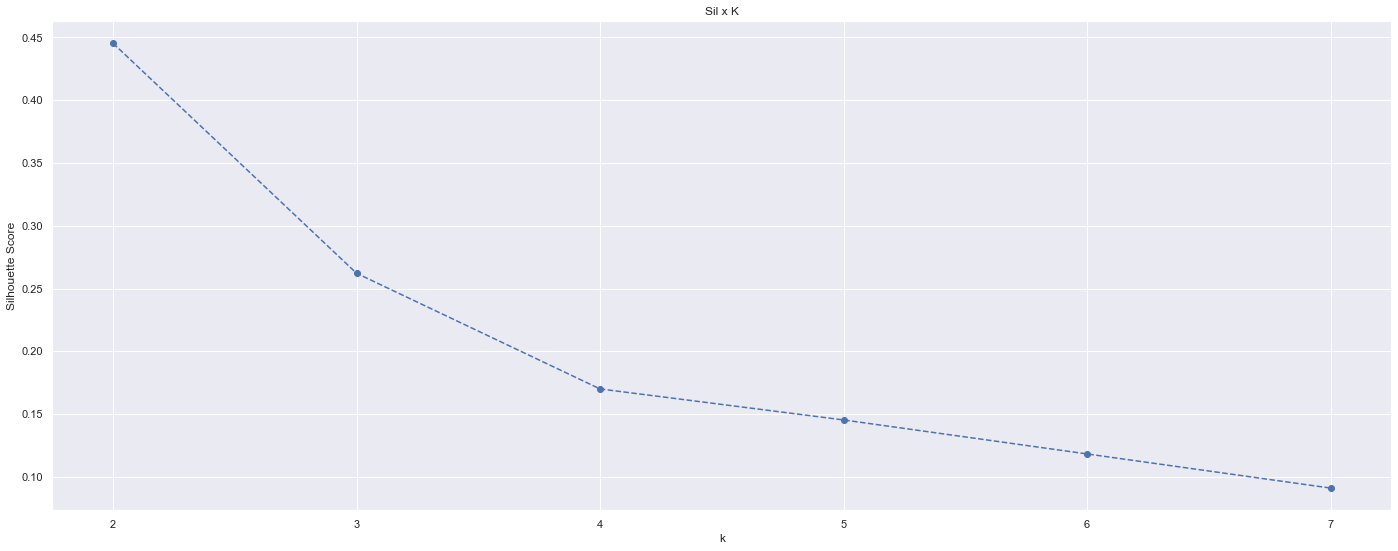

In [91]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

In [92]:
from scipy.cluster import hierarchy as hc

In [93]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

[]

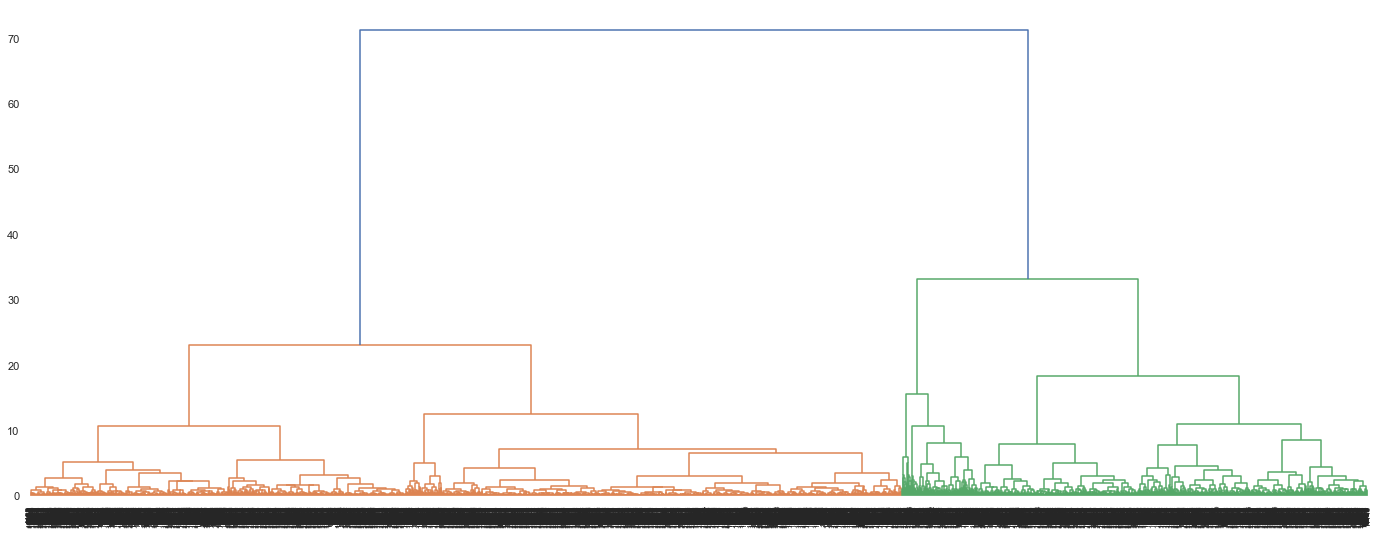

In [94]:
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

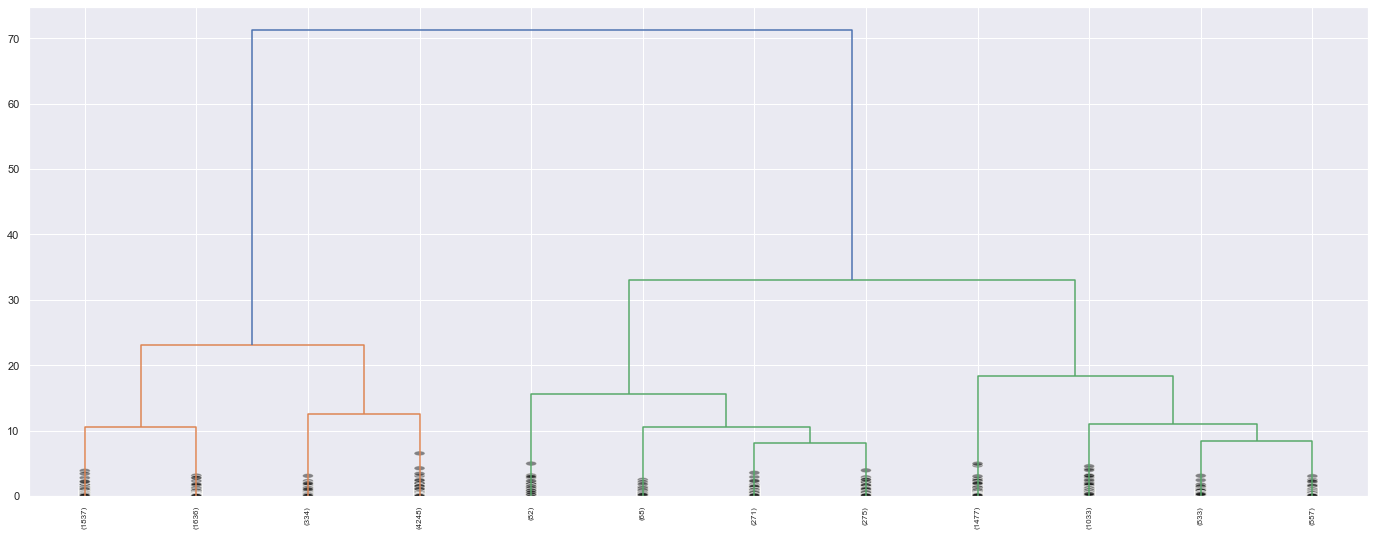

In [95]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

### 7.3.1. HClustering Silhouette Score

In [96]:
from sklearn import metrics as m

In [97]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

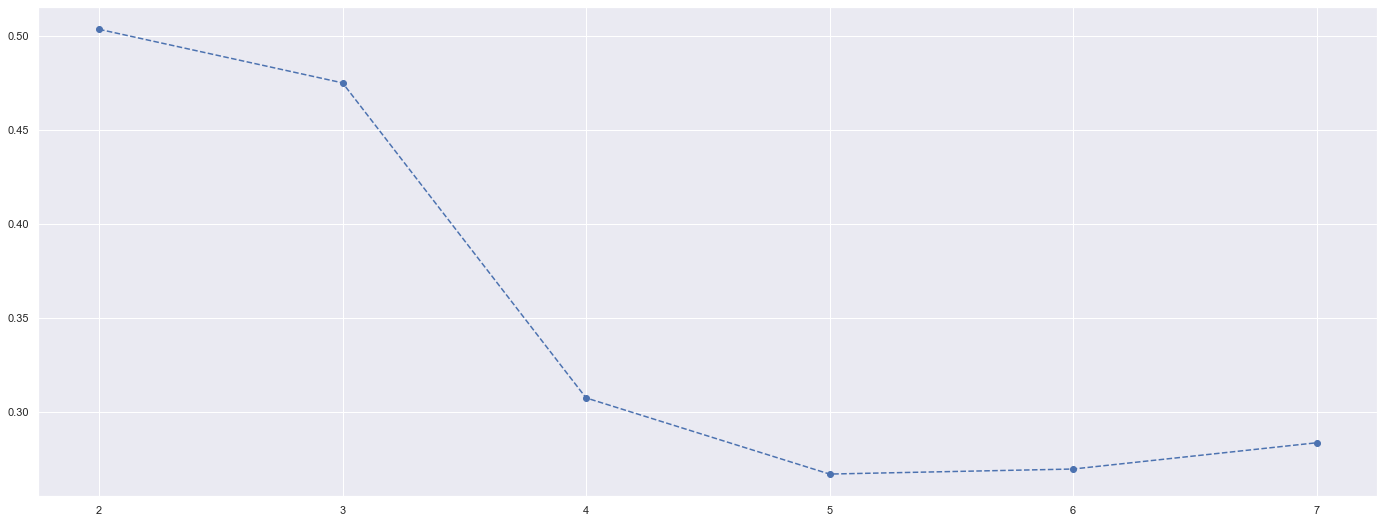

In [98]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [102]:
eps=0.5
min_samples=10

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.6600507269319305
Number of Clusters: 2
[-1  0]


In [274]:
from sklearn.neighbors import NearestNeighbors

In [275]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

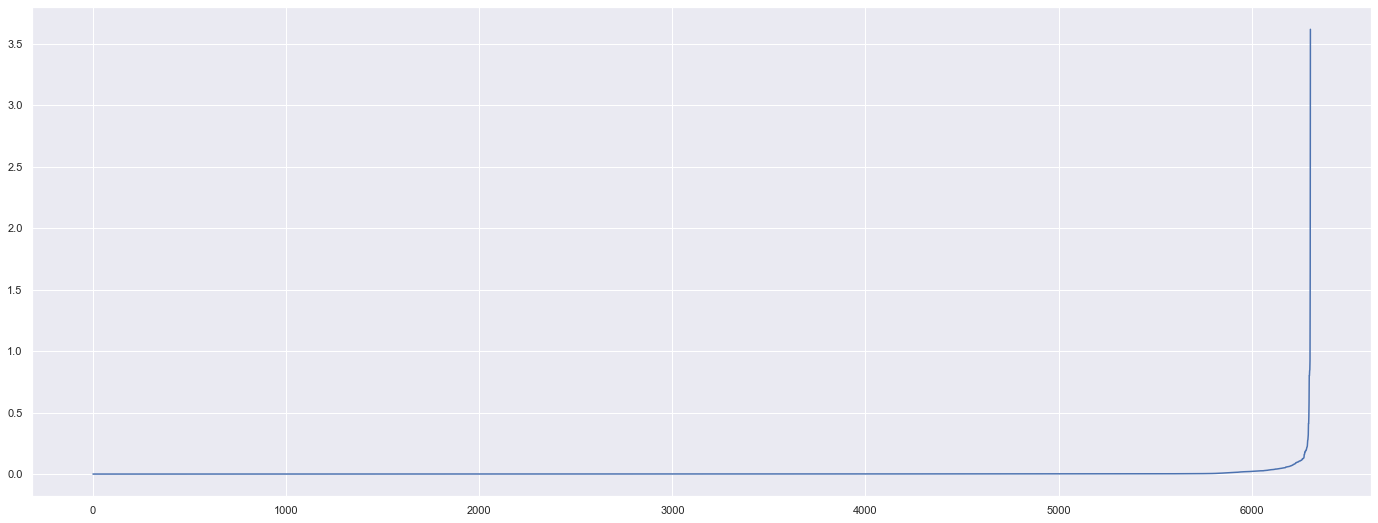

In [276]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

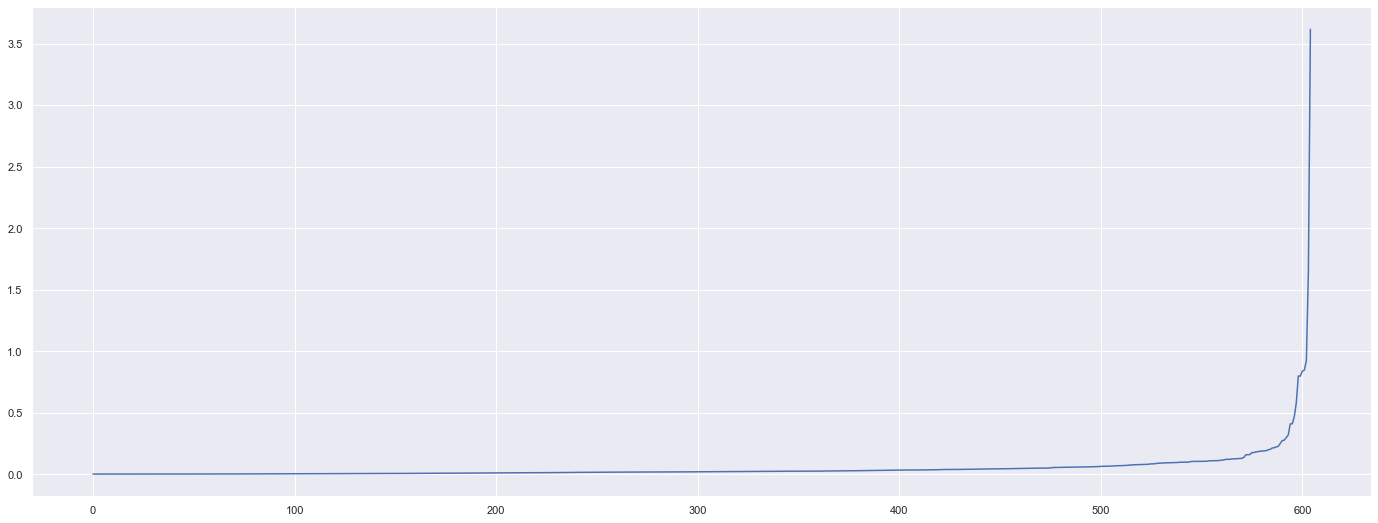

In [277]:
plt.plot( distances[5700:] )

## 7.5. Results

In [103]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list, 
     #'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters

In [104]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7
KMeans,0.540091,0.501327,0.373355,0.354903,0.349580,0.353445
GMM,0.445366,0.262168,0.170027,0.145343,0.118261,0.091074
HC,0.503537,0.475056,0.307589,0.267103,0.269780,0.283734


## 7.6. Silhouette Analysis

In [203]:
len(clusters)

6

 For K = 2. Silhouette Score: 0.5035367289620094
 For K = 3. Silhouette Score: 0.47505556245902697
 For K = 4. Silhouette Score: 0.30758928668103364
 For K = 5. Silhouette Score: 0.2671027229955481
 For K = 6. Silhouette Score: 0.26977985315741554
 For K = 7. Silhouette Score: 0.28373362467832336


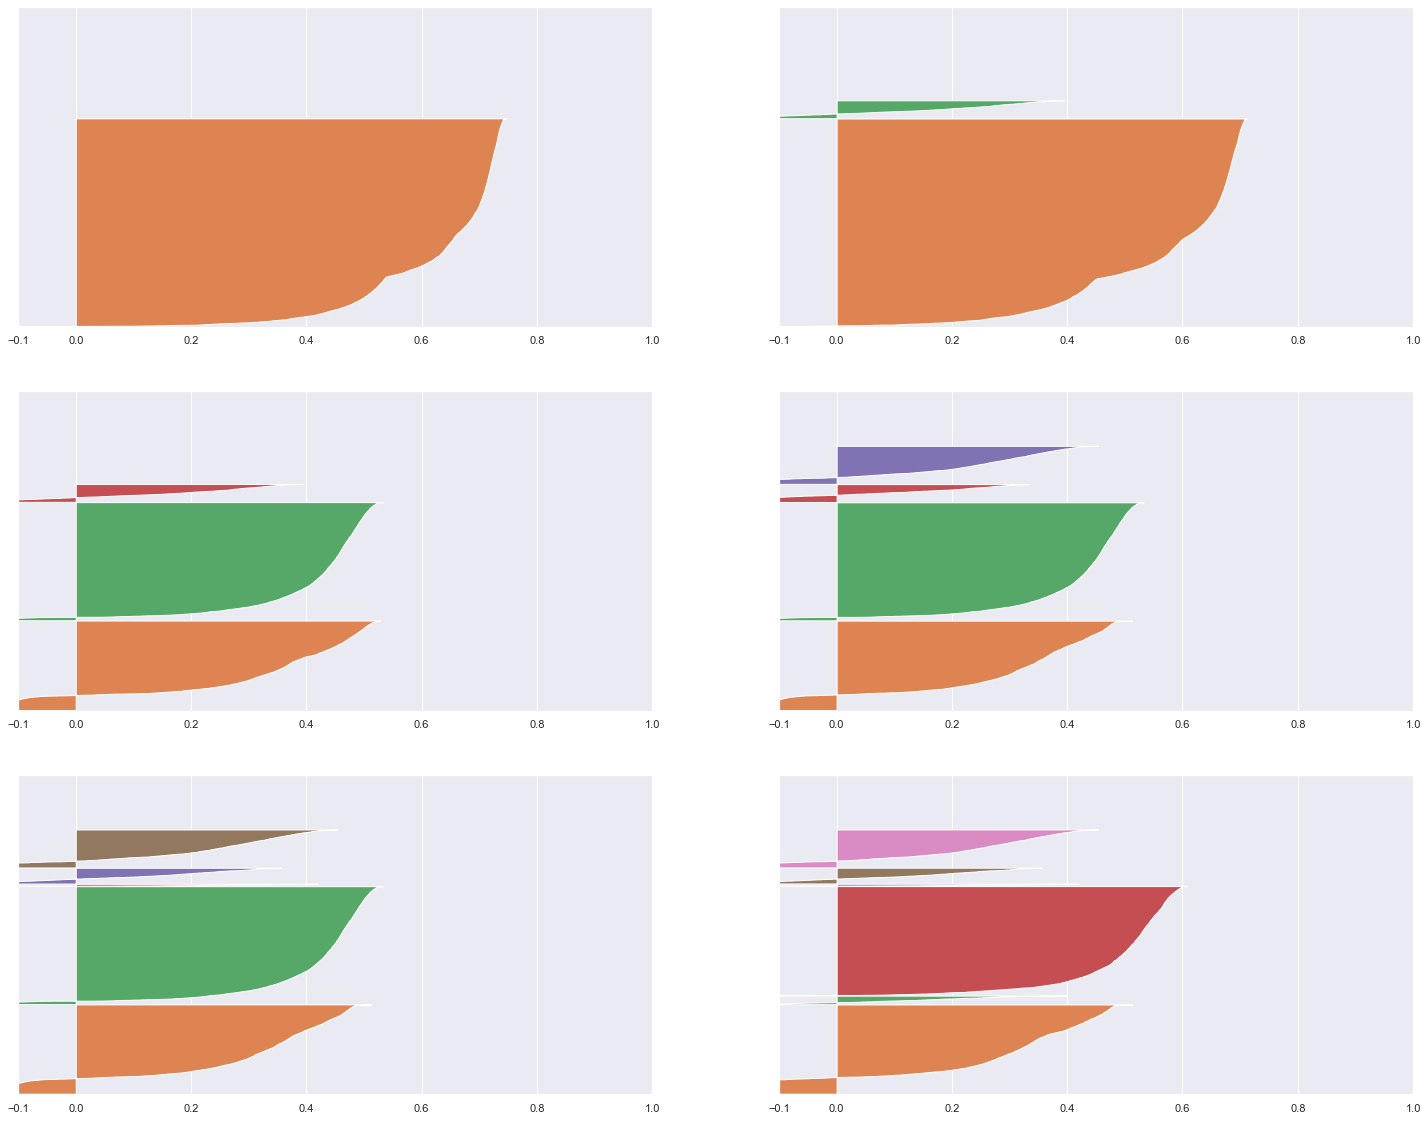

In [105]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# <font color='red'> 8.0 HYPERPARAMETER FINE TUNNING </font>

## 8.1. K-Means

In [154]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42) #max_iter iterações para achar o centróide

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [155]:
## WSS (within-cluster sum of square)
print('WSS Values: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS Values: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Values: 1379.2170668116687
SS Values: 0.37335495952297354


# <font color='red'> 9.0. Cluster Analysis </font>

In [156]:
df9 = df5_p.copy()
df9['cluster'] = labels
df9.head()

,setor_ativ,municipio.uf,class_cidade,faixa_f_renda,trabalhadores,s_renda_media,s_fluxo_pedestre,s_fluxo_veiculos,s_dom_part_perm,s_densidade_populacao_km2,s_tx_cresc_pop,s_tx_cresc_dom,s_tx_cresc_renda_media,s_comercializacao,s_sem_func,s_de_1_4_func,s_de_5_9_func,s_de_10_19_func,s_de_20_49_func,s_de_50_99_func,s_de_100_249_func,s_de_250_499_func,s_de_500_999_func,s_mais1000_func,s_supermercado,s_tt_padaria,s_atacado,s_hipermercado,s_minimercado,s_qtd_criancas,s_qtd_adolescente,s_qtd_jovens,s_qtd_adultos,s_qtd_senior,s_qtd_idosos,s_renda_classe_a,s_renda_classe_b,s_renda_classe_c,s_renda_classe_d,s_renda_classe_e,s_qtd_cnae_agricola,s_qtd_cnae_comercio,s_qtd_cnae_constr_civil,s_qtd_cnae_industria,s_qtd_cnae_servicos,s_qtd_cnae_outros,cluster
0,agropecuaria,ce / miraima,baixa,baixa,23.00,994.06,0.00,0.00,1694.00,18.43,2.06,4.75,3.97,2.87,112.00,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,21.00,793.80,937.13,1105.12,1383.90,604.80,425.25,5679.99,25462.03,374487.69,1108773.40,444018.60,0.00,73.00,4.00,5.00,39.00,7.00,2
1,agropecuaria,ce / nova olinda,baixa,baixa,1264.00,696.12,0.00,0.00,3543.00,90.77,2.34,4.63,0.32,4.22,429.00,68.00,18.00,8.00,2.00,2.00,0.00,0.00,1.00,0.00,0.00,6.00,0.00,1.00,41.00,1678.86,1715.26,2295.58,2988.32,1219.53,808.38,26922.86,95725.72,1030048.60,2655391.45,1177625.80,6.00,267.00,15.00,85.00,192.00,15.02,2
2,agropecuaria,es / cariacica,media_grande,baixa,15231.00,1571.33,4.00,5.00,26791.00,7674.45,0.80,2.69,0.84,13.96,5459.00,728.00,241.00,131.00,64.00,24.00,12.00,4.00,1.00,1.00,15.00,81.00,20.00,3.00,82.00,7783.09,8777.13,10680.60,23024.97,12971.82,7261.40,1638951.49,28847388.19,42235227.22,18590130.37,764230.19,4.00,2558.00,587.00,716.00,3416.00,72.80,0
3,agropecuaria,es / guacui,baixa,baixa,1.00,919.39,0.00,0.00,344.00,13.56,1.11,3.15,1.83,0.87,14.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,147.01,164.03,155.96,258.99,160.98,97.02,0.00,33703.26,185537.15,245980.58,18278.09,2.00,4.00,0.00,0.00,9.00,0.00,2
4,agropecuaria,es / viana,media_pequena,baixa,2488.00,1549.71,2.00,5.00,5480.00,355.60,3.07,4.78,1.66,9.54,1199.00,90.00,42.00,26.00,18.00,8.00,3.00,0.00,0.00,0.00,2.00,9.00,8.00,0.00,45.00,2721.33,2737.80,2464.51,5236.88,2253.78,1048.69,14284.29,834202.36,4639536.42,3910085.53,124749.43,5.00,442.00,172.00,184.00,626.00,22.06,3


In [157]:
df9 = df9.iloc[:, [1, 4, 5, 9, 46]]

In [128]:
#df9 = df9.groupby('municipio.uf').mean().reset_index()

In [158]:
df9.head()

,municipio.uf,trabalhadores,s_renda_media,s_densidade_populacao_km2,cluster
0,ce / miraima,23.00,994.06,18.43,2
1,ce / nova olinda,1264.00,696.12,90.77,2
2,es / cariacica,15231.00,1571.33,7674.45,0
3,es / guacui,1.00,919.39,13.56,2
4,es / viana,2488.00,1549.71,355.60,3


## 9.1. Visualization Inspection

In [159]:
fig = px.scatter_3d(df9, x='trabalhadores', y='s_renda_media', z='s_densidade_populacao_km2', color='cluster')
fig.show();

## 9.2. 2d plot

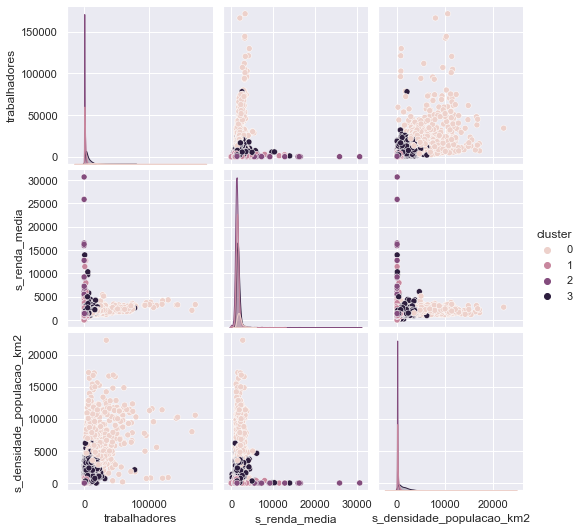

In [160]:
df_viz = df9.drop( columns='municipio.uf', axis=1 )
sns.pairplot( df_viz, hue='cluster' );

## 9.1. Cluster Profile

In [161]:
df_cluster = pd.DataFrame()
# Number of municipio
df_cluster = df9[['municipio.uf', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_municipio'] = 100*(df_cluster['municipio.uf'] / df_cluster['municipio.uf'].sum())

# Avg trabalhador
df_avg_trabalhador = df9[['trabalhadores', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'trabalhadores':'avg_trabalhadores'})
df_cluster = pd.merge(df_cluster, df_avg_trabalhador, how='inner', on='cluster')

# Avg renda media
df_avg_renda_media = df9[['s_renda_media', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'s_renda_media':'avg_renda_media'})
df_cluster = pd.merge(df_cluster, df_avg_renda_media, how='inner', on='cluster')

# Avg pop total
df_avg_pop_total = df9[['s_densidade_populacao_km2', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'s_densidade_populacao_km2':'avg_dens_pop'})
df_cluster = pd.merge(df_cluster, df_avg_pop_total, how='inner', on='cluster')

In [162]:
df_cluster.sort_values('avg_renda_media', ascending=False)

,cluster,municipio.uf,perc_municipio,avg_trabalhadores,avg_renda_media,avg_dens_pop
0,0,688,5.57,23664.62,1926.55,6151.84
3,3,3009,24.36,5636.50,1621.67,1285.86
1,1,3530,28.58,1356.52,1428.52,153.66
2,2,5124,41.49,795.88,1336.94,84.11


### Cluster 01:  ( Candidatos a Vem de Bolo ) - <font color='red'>DESATUALIZADO</font>
    - Número de Municípios: 7 (0.11% of customers )
    - N° médio de Trabalhadores: 73.300.725
    - Renda Média: R$ 4.392.164,38
    - População Média: 199.371.658 hab
        
### Cluster 02:
    - Número de Municípios: 88 (1,39% of customers )
    - N° médio de Trabalhadores: 4.846.865
    - Renda Média: R$ 628.523,23
    - População Média: 19.159.968 hab

### Cluster 03:
    - Número de Municípios: 6210 (98,58% of customers )
    - N° médio de Trabalhadores: 40.246
    - Renda Média: R$ 9.894,02
    - População Média: 206.295 hab


In [163]:
df9[df9['cluster'] == 0].sort_values('s_renda_media', ascending=False).head(10)

,municipio.uf,trabalhadores,s_renda_media,s_densidade_populacao_km2,cluster
5722,rj / rio de janeiro,28540.00,5416.16,4777.76,0
11054,rj / macae,30025.67,5112.86,4996.89,0
3551,rj / macae,30389.67,5038.64,4799.41,0
6677,sc / florianopolis,129672.00,4296.13,876.01,0
11641,sc / florianopolis,120992.96,4113.94,776.79,0
5771,sp / sao bernardo do campo,3851.00,4079.06,3401.77,0
8342,rj / macae,25394.20,4064.20,4820.08,0
4476,sc / florianopolis,102675.12,3792.98,801.48,0
7316,df / brasilia,17062.64,3784.33,3125.88,0
7874,pa / belem,9569.50,3730.38,11237.91,0
